In [2]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from random import randint
import  random
import os
os.chdir('C:/Users/Travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')
import winsound

from cmath import nan

sound_file = "data/audio/Jobs Done.wav"

def play_jobs_done():
    winsound.PlaySound(sound_file, winsound.SND_FILENAME)


bad_sound_file = 'data/audio/Danger Will Robinson.wav'

def play_danger():
    winsound.PlaySound(bad_sound_file, winsound.SND_FILENAME)

In [2]:
# Load fights df
fights_df = pd.read_csv('data/final/aggregates/Fight_DF.csv')
print(fights_df.shape)
fights_df.head()

(5754, 80)


,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.00,1.000,13,28,0,0,0.464286,0.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.00,1.000,1,1,3,3,1.000000,1.0
2,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.00,0.000,0,0,0,0,0.000000,0.0
3,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,3,8,0.75,0.375,10,17,0,0,0.588235,0.0
4,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0,1,1.00,0.000,14,20,0,0,0.700000,0.0


In [3]:
# checkout A_Sub_Attempts_att
fights_df['A_Sub_Attempts_att'].value_counts()

0.0    5754
Name: A_Sub_Attempts_att, dtype: int64

In [4]:
fights_df.columns.to_list()

['Fighter_A',
 'Fighter_B',
 'A_Kd',
 'B_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'B_Sig_strike_land',
 'B_Sig_strike_att',
 'A_Sig_strike_percent',
 'B_Sig_strike_percent',
 'A_Total_Strikes',
 'B_Total_Strikes',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'B_Total_Strikes_land',
 'B_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'B_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'B_Takedowns_land',
 'B_Takedowns_att',
 'A_Takedown_percent',
 'B_Takedown_percent',
 'A_Sub_Attempts_land',
 'A_Sub_Attempts_att',
 'B_Sub_Attempts_land',
 'B_Sub_Attempts_att',
 'A_Sub_Success_Percent',
 'B_Sub_Success_Percent',
 'A_Rev',
 'B_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'B_Ctrl_time_min',
 'B_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'B_Ctrl_time_tot',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'fight_id',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'B_Head_Strikes_land',
 'B_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'B_Head_Strik

### Add Fighter Odds

Makes sense to do it before doubling the dataframe

In [5]:
# Load Fighter Odds
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv')

print(f' df shape: {odds_by_fighter.shape}')
odds_by_fighter.head()

 df shape: (24396, 8)


,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0
2,Georges St-Pierre,-275.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,NaN
3,Thiago Alves,250.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-6.0
4,Dan Henderson,-200.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,4.0


In [6]:
# Split the 'event_ufcstats_url' column by '/' and get the last element from the resulting list, 
# then set it as a new column named 'event_code'
odds_by_fighter['event_code'] = odds_by_fighter['event_ufcstats_url'].str.split('/').str[-1] 

# Remove leading and trailing whitespace from the 'fighter' column
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()

# Show the first three rows of the resulting DataFrame
odds_by_fighter.head(3)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0
2,Georges St-Pierre,-275.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,NaN,0ee783aa00e468f0


In [7]:
event_data = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [8]:
# Remove whitespace from left and right of the values in the column 'Fighter1'
event_data['Fighter1'] = event_data['Fighter1'].str.strip()

# Remove whitespace from left and right of the values in the column 'Fighter2'
event_data['Fighter2'] = event_data['Fighter2'].str.strip()

# Print the first 3 rows of the DataFrame to verify changes made
event_data.head(3)

,Unnamed: 0.1,Unnamed: 0,W/L,Weight class,Method,Round,Time,Fighter1,Fighter2,F1_Kd,F2_Kd,F1_Str,F2_Str,F1_Td,F2_Td,F1_Sub,F2_Sub,fight_num,event_id,fight_link
0,0,0,win,Heavyweight,KO/TKO Punches,3,4:23,Ciryl Gane,Tai Tuivasa,1,1,110,29,0,0,0,0,1,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/810c9da0...
1,1,1,win,Middleweight,U-DEC,3,5:00,Robert Whittaker,Marvin Vettori,0,0,74,33,1,0,0,0,2,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/b8ca1acd...
2,2,2,win,Middleweight,U-DEC,3,5:00,Nassourdine Imavov,Joaquin Buckley,0,0,51,46,2,0,2,0,3,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/20f316f9...


In [9]:
# Make sure the formatting is the same

event_data['event_id'] = event_data['event_id'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)

In [10]:
# pick random row from odds_by_fighter
rand_row = odds_by_fighter.sample(1)
rand_row

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code
12198,Rountree points handicap -3½,-150.0,NaN,https://www.bestfightodds.com/events/ufc-fight...,http://ufcstats.com/event-details/aa3153a9941b...,ufc-fight-night-140-magny-vs-ponzinibbio-1578,UFC Fight Night: Magny vs. Ponzinibbio,NaN,aa3153a9941b4d44


In [11]:
# Filter the event_data DataFrame where the 'event_id' column matches the value of the first element in the 'rand_row' DataFrame's 'event_code' column
test_data = event_data[event_data['event_id'] == rand_row['event_code'].values[0]]

# Print the resulting DataFrame
print(test_data)

      Unnamed: 0.1  Unnamed: 0  W/L         Weight class  \
3878          3878           0  win         Welterweight   
3879          3879           1  win        Featherweight   
3880          3880           2  win    Light Heavyweight   
3881          3881           3  win         Middleweight   
3882          3882           4  win         Bantamweight   
3883          3883           5  win  Women's Strawweight   
3884          3884           6  win         Welterweight   
3885          3885           7  win            Flyweight   
3886          3886           8  win        Featherweight   
3887          3887           9  win         Welterweight   
3888          3888          10  win          Lightweight   
3889          3889          11  win        Featherweight   

                     Method  Round  Time              Fighter1  \
3878          KO/TKO  Punch      4  2:36  Santiago Ponzinibbio   
3879         KO/TKO  Elbows      3  4:09         Ricardo Lamas   
3880          KO/TKO 

In [12]:
def grab_fight_url(fighter, event_code):
        try:
                data = event_data[event_data['event_id'] == event_code]
                data1 = data[data['Fighter1'] == fighter]
                data2 = data[data['Fighter2'] == fighter]
                data3 = pd.concat([data1, data2])

                return data3['fight_link'].values[0]
        except:
                return np.nan

In [13]:
# test
grab_fight_url('Robert Whittaker', '00a905a4a4a2b071')

'http://www.ufcstats.com/fight-details/b8ca1acdf3dc2f58'

In [14]:
# add fight urls to odds by fighter
odds_by_fighter['fight_url'] = odds_by_fighter.apply(lambda row: grab_fight_url(row['fighter'], row['event_code']), axis=1)

In [15]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...


In [16]:
# add columns 'odds' to odds by fighter, where odds is equal to the 5D column unless it is nan, then it is equal to the Ref column
odds_by_fighter['odds'] = odds_by_fighter.apply(lambda row: row['5D'] if np.isnan(row['5D']) == False else row['Ref'], axis=1)

In [17]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url,odds
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,-225.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,205.0


In [18]:
# save odds by fighter with fight urls
odds_by_fighter.to_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv', index=False)

### Double the Fights_DF

To ensure that we are measuring both fighters equally, I double the dataframe to create a version of each fight where the A fighter and B Fighter are switched, along with all of their data.

In [19]:
# Create the double fights df (switching A and B)
fights_df2 = fights_df.copy()

# switch all _A and A_ to _C and C_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_A', 'Fighter_C')
fights_df2.columns = fights_df2.columns.str.replace('A_', 'C_')

# switch all _B and B_ to _A and A_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_B', 'Fighter_A')
fights_df2.columns = fights_df2.columns.str.replace('B_', 'A_')

# switch all _C and C_ to _B and B_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_C', 'Fighter_B')
fights_df2.columns = fights_df2.columns.str.replace('C_', 'B_')

fights_df2.head()

,Fighter_B,Fighter_A,B_Kd,A_Kd,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_percent,A_Sig_strike_percent,...,A_Clinch_Strikes_land,A_Clinch_Strikes_att,B_Clinch_Strikes_percent,A_Clinch_Strikes_percent,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_percent,A_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.00,1.000,13,28,0,0,0.464286,0.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.00,1.000,1,1,3,3,1.000000,1.0
2,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.00,0.000,0,0,0,0,0.000000,0.0
3,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,3,8,0.75,0.375,10,17,0,0,0.588235,0.0
4,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0,1,1.00,0.000,14,20,0,0,0.700000,0.0


In [20]:
# add the new columns to the original df
double_fights_df = pd.concat([fights_df, fights_df2], axis=0)
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.0,1.0,13,28,0,0,0.464286,0.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.0,1.0,1,1,3,3,1.000000,1.0
2,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.0,0.0,0,0,0,0,0.000000,0.0


In [21]:
double_fights_df.to_csv('data/final/aggregates/Fight_DF_V2.csv', index=False)

In [22]:
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.0,1.0,13,28,0,0,0.464286,0.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.0,1.0,1,1,3,3,1.000000,1.0
2,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.0,0.0,0,0,0,0,0.000000,0.0


## Add Odds by Fighter to FightsDf

### Load Point for OddsByFighter

In [23]:
# load
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv')

#### Note: We want to use ufcstats Urls as our connector

We could also just use the event code if that isnt working for some reason

In [24]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url,odds
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,-225.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,205.0


In [25]:
# make sure formatting is the same (string)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
double_fights_df['event_url'] = double_fights_df['event_url'].astype(str)

# make sure name formatting is same
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()
double_fights_df['Fighter_A'] = double_fights_df['Fighter_A'].str.strip()
double_fights_df['Fighter_B'] = double_fights_df['Fighter_B'].str.strip()

In [26]:
# Add column "Event Code", which is event code for ufcstats
double_fights_df['event_code'] = double_fights_df['event_url'].str.split('/').str[-1]
double_fights_df['event_code'] = double_fights_df['event_code'].astype(str)

In [27]:
# check the differences between double_fights_df['event_code'] and odds_by_fighter['event_code']
dfights = double_fights_df['event_code'].unique()
odds = odds_by_fighter['event_code'].unique()

# check differences in list
diff = [x for x in dfights if x not in odds]

In [28]:
diff2 = [x for x in odds if x not in dfights]
diff2

[]

### Note: The double fights DF has lots of OUTSIDE of UFC fights, whereas the odds does not. As we want to focus on the UFC events, this is okay. 

In [29]:
# Check Dtypes of odds_by_fighter
odds_by_fighter.dtypes

fighter                object
5D                    float64
Ref                   float64
event_odds_url         object
event_ufcstats_url     object
event_id               object
event_name             object
odds_change           float64
event_code             object
fight_url              object
odds                  float64
dtype: object

In [30]:
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)

In [31]:
# This function takes in an event code and fighter name as parameters
def get_odds_from_obf(event_code, fighter):
    try:
        # Selects data from odds_by_fighter that has the event_code equal to the provided event_code
        data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
        # Filters the above data further by only returning data with the fighter name equal to the provided fighter name
        data = data[data['fighter'] == fighter]
        # Returns the odds value for the fighter in the provided event.
        return data['odds'].values[0]
    except:
        # If any error occurs during the processing above, return NaN
        return np.nan

In [32]:
# test
get_odds_from_obf('805ad1801eb26abb', 'Holly Holm')

-125.0

In [33]:
double_fights_df['Fighter_A_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_B']), axis=1)

In [34]:
# check missing
double_fights_df[double_fights_df['Fighter_A_Odds'].isna()]

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds
9,Rameau Thierry,Sokoudjou Kazuhiro,1,0,26,46,6,23,0.56,0.26,...,0.000000,2,2,0,0,1.000000,0.000000,2549d63da9c456cb,NaN,NaN
49,Gunnar Nelson,Bryan Barberena,0,0,10,11,7,12,0.90,0.58,...,0.000000,7,7,1,1,1.000000,1.000000,e4bb7e483c4ad318,NaN,NaN
50,Iuri Alcantara,Iliarde Santos,0,0,19,37,3,10,0.51,0.30,...,1.000000,6,7,0,0,0.857143,0.000000,030f08370fd1c2bb,NaN,450.0
54,Iuri Alcantara,Wilson Reis,1,0,42,76,23,61,0.55,0.37,...,0.750000,24,37,11,19,0.648649,0.578947,51b0bb73a1da34bc,NaN,195.0
57,Dooho Choi,Kyle Nelson,0,0,50,78,20,58,0.64,0.34,...,0.750000,21,22,0,0,0.954545,0.000000,d26394fc0e8e880a,NaN,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,la Torre,Mike de,0,0,3,6,6,11,0.50,0.54,...,0.500000,0,0,0,0,0.000000,0.000000,05fbfe628658c538,NaN,NaN
5726,Joanne Wood,Valerie Letourneau,2,0,115,208,80,143,0.55,0.55,...,0.863636,9,17,3,3,0.529412,1.000000,563d051c9e769b24,NaN,-150.0
5727,Abel Trujillo,Jamie Varner,1,0,18,79,36,96,0.22,0.37,...,0.527778,0,0,2,4,0.000000,0.500000,fc31f896cde2bc2e,NaN,NaN
5734,James Te,Alexander Gustafsson,0,0,6,6,4,9,1.00,0.44,...,0.000000,6,6,4,6,1.000000,0.666667,88a9bc81271ccd89,NaN,-350.0


In [35]:
# check not missing
double_fights_df[double_fights_df['Fighter_A_Odds'].notna()]

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,1.000000,13,28,0,0,0.464286,0.000000,805ad1801eb26abb,-125.0,105.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,1.000000,1,1,3,3,1.000000,1.000000,1d00756835ca67c9,-600.0,NaN
2,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0.000000,0,0,0,0,0.000000,0.000000,3ae10ac4df3df05c,-400.0,325.0
3,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,0.375000,10,17,0,0,0.588235,0.000000,f54200f1dfb9b5d4,-310.0,280.0
4,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0.000000,14,20,0,0,0.700000,0.000000,d4a12dfa4067742f,-200.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5749,Francis Carmont,Jacare Souza,0,0,19,71,16,47,0.26,0.34,...,1.000000,0,0,6,9,0.000000,0.666667,51b0bb73a1da34bc,435.0,NaN
5750,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,0.30,...,0.480769,0,0,1,2,0.000000,0.500000,53f02bbc41d99432,200.0,-220.0
5751,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,0.46,...,0.000000,0,0,0,0,0.000000,0.000000,d57e6a8971b6d2bd,205.0,-245.0
5752,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,0.28,...,0.000000,0,0,3,8,0.000000,0.375000,ad4e9055bf8cd04d,220.0,-240.0


## Add Odds Change to FightsDf

In [36]:
def get_odds_change_from_obf(event_code, fighter):
        try:
                # First, we filter the odds_by_fighter DataFrame by event code
                data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
                # Then, we filter by the designated fighter
                data = data[data['fighter'] == fighter]

                # We return the odds change value for that fighter and event code
                return data['odds_change'].values[0]
        except:
                return np.nan

In [37]:
# add odds change
double_fights_df['Fighter_A_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_B']), axis=1)


In [38]:
double_fights_df.head(2)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds,Fighter_A_Odds_Change,Fighter_B_Odds_Change
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,28,0,0,0.464286,0.0,805ad1801eb26abb,-125.0,105.0,39.0,49.0
1,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,1,3,3,1.000000,1.0,1d00756835ca67c9,-600.0,NaN,-66.0,NaN


<Axes: xlabel='Count', ylabel='variable'>

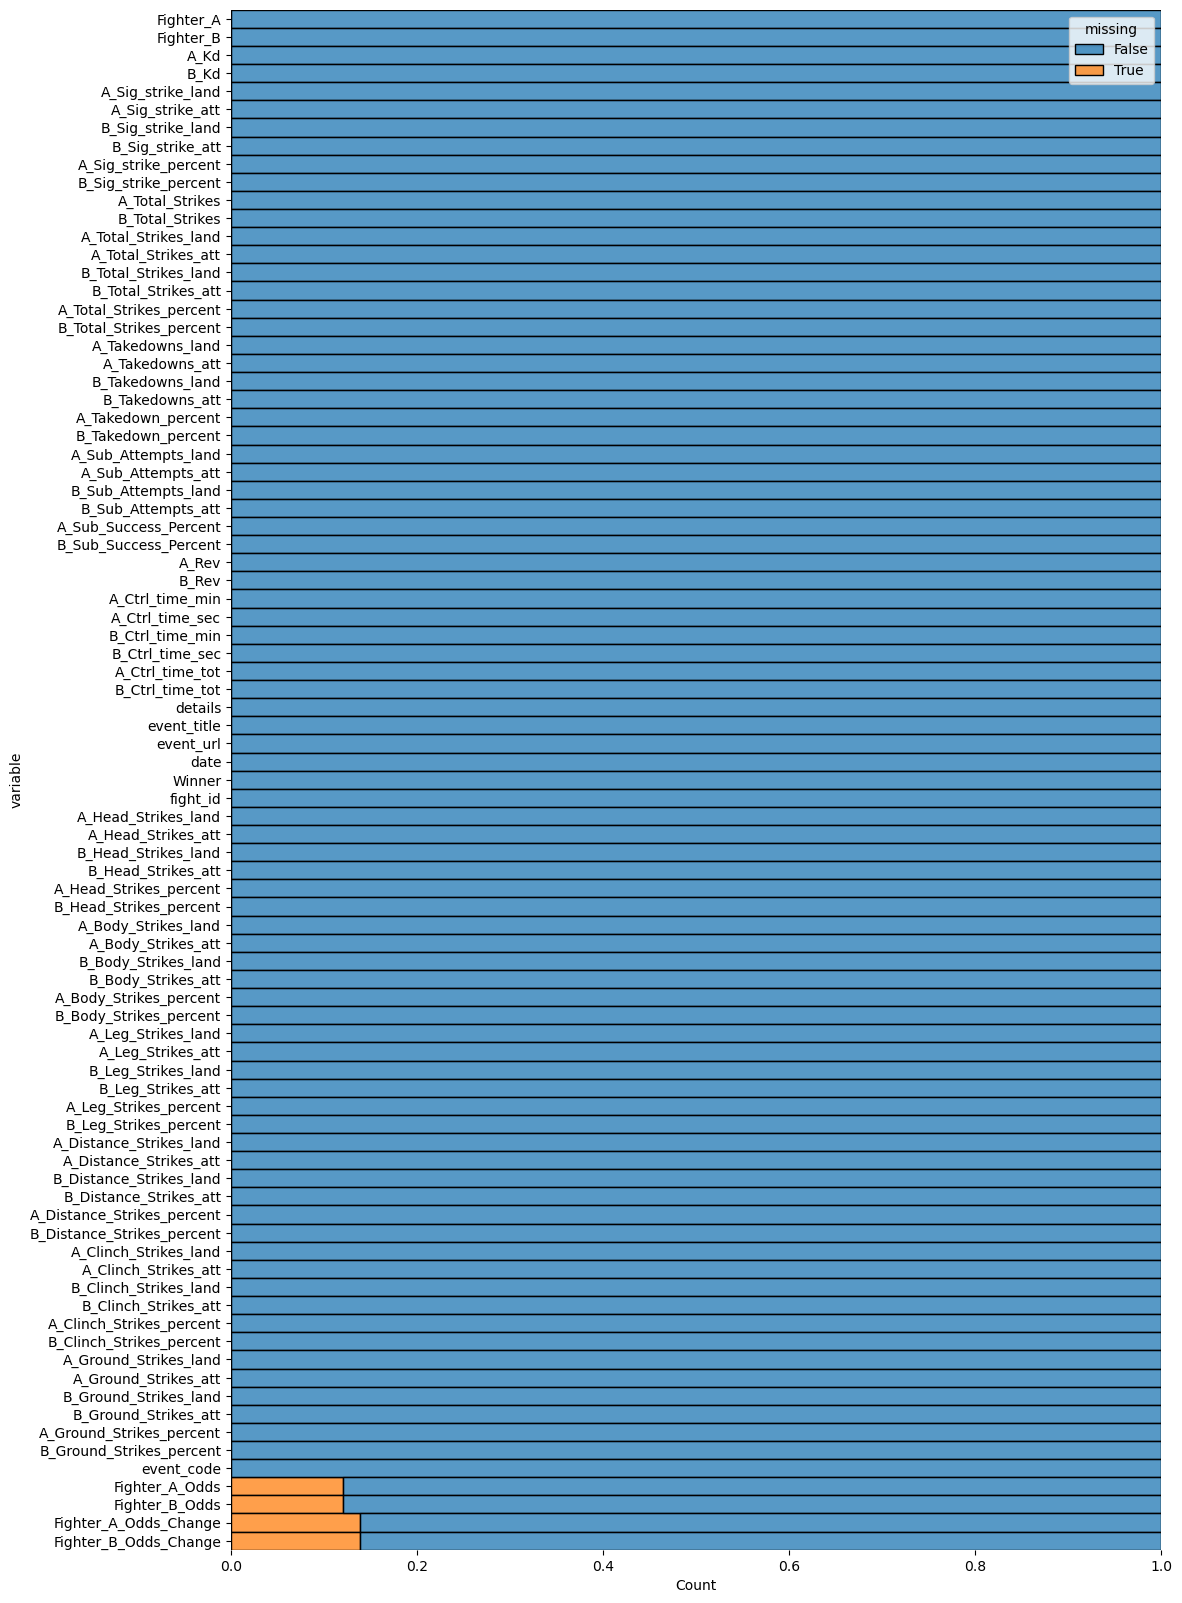

In [39]:
f, ax = plt.subplots(figsize = (12,20))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = double_fights_df.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

### As we know from earlier, we do not have many of these odds because these events were outside of the UFC. Thus, we can drop them. 

In [40]:
double_fights_df = double_fights_df.dropna()
double_fights_df.shape

(8952, 85)

In [41]:
double_fights_df.to_csv('data/final/aggregates/Double_Fights_DF_V1.csv', index=False)

In [42]:
double_fights_df= pd.read_csv('data/final/aggregates/Double_Fights_DF_V1.csv')

In [43]:
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds,Fighter_A_Odds_Change,Fighter_B_Odds_Change
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,28,0,0,0.464286,0.0,805ad1801eb26abb,-125.0,105.0,39.0,49.0
1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,0,0,0.000000,0.0,3ae10ac4df3df05c,-400.0,325.0,-16.0,-19.0
2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,17,0,0,0.588235,0.0,f54200f1dfb9b5d4,-310.0,280.0,23.0,-5.0


In [44]:
# find all objects in df
double_fights_df.select_dtypes(include=['object']).columns

Index(['Fighter_A', 'Fighter_B', 'A_Total_Strikes', 'B_Total_Strikes',
       'details', 'event_title', 'event_url', 'date', 'Winner', 'fight_id',
       'event_code'],
      dtype='object')

In [45]:
# drop A_Total_Strikes and B_Total_Strikes, they were not meant to be here. 
double_fights_df = double_fights_df.drop(['A_Total_Strikes', 'B_Total_Strikes'], axis=1)


## Add Feature: In-Fight Statistic Differentials

This is 

First make sure that there are no Nans or Infs in the data

In [46]:
#check for nans and infs
double_fights_df.isna().sum()

Fighter_A                0
Fighter_B                0
A_Kd                     0
B_Kd                     0
A_Sig_strike_land        0
                        ..
event_code               0
Fighter_A_Odds           0
Fighter_B_Odds           0
Fighter_A_Odds_Change    0
Fighter_B_Odds_Change    0
Length: 83, dtype: int64

In [47]:
# turn infs to nans
double_fights_df = double_fights_df.replace([np.inf, -np.inf], np.nan)

In [48]:
# calculate differences between in-match stats

for col in double_fights_df.columns:
    if col.startswith('A_'):
        new_col = col.replace('A_', 'Dif_')
        double_fights_df[new_col] = double_fights_df[col] - double_fights_df[col.replace('A_', 'B_')]
    else:
        continue

double_fights_df

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,Dif_Leg_Strikes_percent,Dif_Distance_Strikes_land,Dif_Distance_Strikes_att,Dif_Distance_Strikes_percent,Dif_Clinch_Strikes_land,Dif_Clinch_Strikes_att,Dif_Clinch_Strikes_percent,Dif_Ground_Strikes_land,Dif_Ground_Strikes_att,Dif_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,0.191033,75,91,0.155590,-3,-3,0.000000,13,28,0.464286
1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,-0.035714,26,7,0.234021,2,1,1.000000,0,0,0.000000
2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,0.000000,3,-4,0.160714,0,-4,0.375000,10,17,0.588235
3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0.000000,-2,-2,-0.500000,3,2,1.000000,14,20,0.700000
4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,0.33,...,0.537838,38,48,0.109488,-1,-2,-0.500000,1,2,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,Marcus Davis,Mike Swick,0,0,31,55,32,86,0.56,0.37,...,-0.200000,7,12,0.108225,5,-3,0.373529,-13,-40,0.422222
8948,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,0.30,...,-0.200000,-2,-29,0.057606,-18,-41,0.155594,-1,-2,-0.500000
8949,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,0.46,...,0.300000,-47,14,-0.272763,0,0,0.000000,0,0,0.000000
8950,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,0.28,...,-0.750000,-6,-10,-0.166667,0,0,0.000000,-3,-8,-0.375000


In [49]:
# check for infs
double_fights_df.isna().sum()
# only display columns with nans
double_fights_df.isna().sum()[double_fights_df.isna().sum() > 0]

Series([], dtype: int64)

In [50]:
# add difference in odds
double_fights_df['Dif_Odds'] = double_fights_df['Fighter_A_Odds'] - double_fights_df['Fighter_B_Odds']

#### Add Distribution Stat Features

now fights = double_fights_df, for ease

In [51]:
fights = double_fights_df

In [52]:
def get_fighter_running_dist_stats(fighter, date, col_to_get, stat_to_calc):

    # retrieve data for all fights involving the given fighter
    data = fights[(fights['Fighter_A'] == fighter) | (fights['Fighter_B'] == fighter)]

    # convert date strings to datetime objects
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])

    # filter data to only include fights before the given date
    data = data[data['date'] < datey]

    # create an empty dataframe to store fighter data
    fighter_data = pd.DataFrame()

    # retrieve data for fights where the given fighter is Fighter A
    fighterA_df = fights[fights['Fighter_A'] == fighter]
    # retrieve data for fights where the given fighter is Fighter B
    fighterB_df = fights[fights['Fighter_B'] == fighter]

    # select relevant columns from Fighter A data and rename columns for consistency
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)

    # select relevant columns from Fighter B data and rename columns for consistency
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)

    # append Fighter A and Fighter B data to the fighter_data dataframe
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the chosen statistic based on the input parameter
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  

    # return the chosen statistic
    return x

#### Get Non-specific column names for Feature Creation

In [53]:
# This code creates three lists of column names from a dataframe called 'fights'
# The first list contains column names with 'Dif_' in them
# The second list contains column names that start with 'A_'
# The third list combines the second and first list

dif_cols = [n for n in fights.columns if 'Dif_' in n]
A_cols = [n for n in fights.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols

# This code creates a new dataframe containing the second list of column names without the 'A_' prefix
# It then creates a list of unique column name suffixes

A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [54]:
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [55]:
# test get_fighter_running_dist_stats
get_fighter_running_dist_stats('Khabib Nurmagomedov', '2020-01-18', 'Sig_strike_land', 'mean')

55.75

These are split because they were causing problems when running all at once

In [56]:
# Mean First

for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_1.csv', index=False)

In [57]:
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_2.csv', index=False)

In [58]:
# Now Median
for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'median'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_3.csv', index=False)

In [59]:
# fighter 2 Median
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'median'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_4.csv', index=False)

In [60]:
# Now Std
for col in the_cols:
    fights['A_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_5.csv', index=False)


In [61]:
# fighter 2 Std
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_6.csv', index=False)

New Version:

In [62]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2.csv', index=False)

In [63]:
# Load point for fights df
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V2.csv')

### Feature: Top-Down Averages (typical UFC Style)

In [64]:
def get_top_down_averages(fighter, date, col_to_get, dataframe):

    # for each column in all_metric_cols, calculate the top-down averages, as opposed to bottom-up
    data = dataframe[(dataframe['Fighter_A'] == fighter) | (dataframe['Fighter_B'] == fighter)]

    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()


    # fighterA df
    fighterA_df = dataframe[dataframe['Fighter_A'] == fighter]
    fighterB_df = dataframe[dataframe['Fighter_B'] == fighter]
    
    # keep only the fighters columns date, FighterA, and the col_to_get, 
    # do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the average
    tot = fighter_data[col_to_get].sum()
    num = fighter_data[col_to_get].count()
    x = tot / num
    return x

In [65]:
# delete rolling cols from the_cols
the_cols = [n for n in the_cols if 'Rolling' not in n]
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [66]:


for col in the_cols:
    fights['A_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_A'], row['date'], col, fights), axis=1)

In [67]:
for col in the_cols:
    fights['B_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_B'], row['date'], col, fights), axis=1)

In [68]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

PICK UP HERE 4.16

In [2]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

### Add Opponent Stats

In [3]:
def get_opponent_averages(datafrm, date, col_to_get, fighter):
    col_to_get = 'B_' + col_to_get
    data = datafrm[(datafrm['Fighter_A'] == fighter) | (datafrm['Fighter_B'] == fighter)]
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    fighter_data = pd.DataFrame()

    fighterA_df = datafrm[datafrm['Fighter_A'] == fighter]
    fighterB_df = datafrm[datafrm['Fighter_B'] == fighter]

    # switch A_ and B_ to B_ and A_ in fighterB_df
    fighterB_df.columns = [n.replace('A_', 'C_') if n.startswith('A_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('B_', 'D_') if n.startswith('B_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('C_', 'B_') if n.startswith('C_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('D_', 'A_') if n.startswith('D_') else n for n in fighterB_df.columns]

    # copy fighter_A and fighter_B columns to new dataframe, then switch fighter_A and fighter_B columns

    fighterB_df.rename(columns={'Fighter_A': 'Fighter_A2', 'Fighter_B': 'Fighter_B2'}, inplace=True)
    fighterB_df.rename(columns={'Fighter_B2': 'Fighter_A', 'Fighter_A2': 'Fighter_B'}, inplace=True)

    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get sum of col to get
    col_sum = fighter_data[col_to_get].sum()
    # get number of fights
    num_fights = len(fighter_data)
    # get average
    avg = col_sum / num_fights

    return avg


In [4]:
# test
get_opponent_averages(fights, '2017-01-01', 'Sig_strike_land', 'Conor McGregor')

37.42857142857143

In [5]:
cols = [n for n in fights.columns if n.startswith('B_')]
cols = [n for n in cols if 'topdown_' not in n]
cols = [n for n in cols if 'Rolling_' not in n]
cols = [n for n in cols if 'Dif_' not in n]

In [6]:
# delete the first 2 characters of each in col
cols2 = pd.DataFrame(cols)
cols2['nonspecific'] = cols2[0].str[2:]
cols2

# get unique values
the_cols = list(cols2['nonspecific'].unique())
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

Get Opponent Averages (2-hours runtime)

In [7]:
n=0
# save as we go to intermediate_data, so we don't have to start over if we get an error

# # check to see which columns have already been done
# done_cols = [n for n in os.listdir('data/intermediate_data/') if n.startswith('Opponent_Averages_')]
# done_cols = [n.replace('Opponent_Averages_', '') for n in done_cols]
# done_cols = [n.replace('_.csv', '') for n in done_cols]
# # remove the done columns from the_cols
# the_cols = [n for n in the_cols if n not in done_cols]
# print('Cols Remaining:' + str(len(the_cols)))

# loop through the remaining columns
for col in the_cols:
    try:
        fights['A_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_A']), axis=1)
        fights['B_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_B']), axis=1)
        # save to csv
        fights.to_csv('data/intermediate_data/Opponent_Averages_{}_.csv'.format(col))

        n = n+1
        print(f' {col}, #{n} / {len(cols)} done.')
    except:
        print(f'Error on {col}')
        play_danger()

play_jobs_done()

 Kd, #1 / 35 done.
 Sig_strike_land, #2 / 35 done.
 Sig_strike_att, #3 / 35 done.
 Sig_strike_percent, #4 / 35 done.
 Total_Strikes_land, #5 / 35 done.
 Total_Strikes_att, #6 / 35 done.
 Total_Strikes_percent, #7 / 35 done.
 Takedowns_land, #8 / 35 done.
 Takedowns_att, #9 / 35 done.
 Takedown_percent, #10 / 35 done.
 Sub_Attempts_land, #11 / 35 done.
 Sub_Attempts_att, #12 / 35 done.
 Sub_Success_Percent, #13 / 35 done.
 Rev, #14 / 35 done.
 Ctrl_time_min, #15 / 35 done.
 Ctrl_time_sec, #16 / 35 done.
 Ctrl_time_tot, #17 / 35 done.
 Head_Strikes_land, #18 / 35 done.
 Head_Strikes_att, #19 / 35 done.
 Head_Strikes_percent, #20 / 35 done.
 Body_Strikes_land, #21 / 35 done.
 Body_Strikes_att, #22 / 35 done.
 Body_Strikes_percent, #23 / 35 done.
 Leg_Strikes_land, #24 / 35 done.
 Leg_Strikes_att, #25 / 35 done.
 Leg_Strikes_percent, #26 / 35 done.
 Distance_Strikes_land, #27 / 35 done.
 Distance_Strikes_att, #28 / 35 done.
 Distance_Strikes_percent, #29 / 35 done.
 Clinch_Strikes_land, #3

In [8]:
# load all data in data/intermediate_data, adding columns to fights
for file in os.listdir('data/intermediate_data/'):
    if file.startswith('Opponent_Averages_'):
        print(file)
        df = pd.read_csv('data/intermediate_data/' + file)
        fights_cols = list(fights.columns)
        df_cols = list(df.columns)
        cols_to_add = [n for n in df_cols if n not in fights_cols]
        for col in cols_to_add:
            fights[col] = df[col]
        
fights

Opponent_Averages_Body_Strikes_att_.csv
Opponent_Averages_Body_Strikes_land_.csv
Opponent_Averages_Body_Strikes_percent_.csv
Opponent_Averages_Clinch_Strikes_att_.csv
Opponent_Averages_Clinch_Strikes_land_.csv
Opponent_Averages_Clinch_Strikes_percent_.csv
Opponent_Averages_Ctrl_time_min_.csv
Opponent_Averages_Ctrl_time_sec_.csv
Opponent_Averages_Ctrl_time_tot_.csv
Opponent_Averages_Distance_Strikes_att_.csv
Opponent_Averages_Distance_Strikes_land_.csv
Opponent_Averages_Distance_Strikes_percent_.csv
Opponent_Averages_Ground_Strikes_att_.csv
Opponent_Averages_Ground_Strikes_land_.csv
Opponent_Averages_Ground_Strikes_percent_.csv
Opponent_Averages_Head_Strikes_att_.csv
Opponent_Averages_Head_Strikes_land_.csv
Opponent_Averages_Head_Strikes_percent_.csv
Opponent_Averages_Kd_.csv
Opponent_Averages_Leg_Strikes_att_.csv
Opponent_Averages_Leg_Strikes_land_.csv
Opponent_Averages_Leg_Strikes_percent_.csv
Opponent_Averages_Rev_.csv
Opponent_Averages_Sig_strike_att_.csv
Opponent_Averages_Sig_strik

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Opp_Avg_Clinch_Strikes_att,A_Opp_Avg_Clinch_Strikes_percent,B_Opp_Avg_Clinch_Strikes_percent,A_Opp_Avg_Ground_Strikes_land,B_Opp_Avg_Ground_Strikes_land,A_Opp_Avg_Ground_Strikes_att,B_Opp_Avg_Ground_Strikes_att,A_Opp_Avg_Ground_Strikes_percent,B_Opp_Avg_Ground_Strikes_percent,Unnamed: 0.1
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,5.375000,0.730844,0.544167,1.615385,3.875000,1.923077,7.375000,0.333333,0.316369,0
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,2.000000,0.055556,1.000000,4.222222,0.000000,6.000000,0.000000,0.448148,0.000000,1
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,8.500000,0.509722,0.836538,3.166667,5.000000,4.000000,8.500000,0.519841,0.294118,2
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,4.000000,0.592727,0.346134,4.812500,6.375000,6.125000,11.000000,0.619719,0.631721,3
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,0.000000,0.313235,0.000000,0.875000,5.500000,1.875000,7.000000,0.119318,0.666667,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,8947,Marcus Davis,Mike Swick,0,0,31,55,32,86,0.56,...,14.428571,0.499597,0.585928,4.333333,2.142857,9.777778,3.428571,0.460261,0.423810,8947
8948,8948,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,...,7.375000,0.254731,0.517431,7.000000,5.583333,11.500000,7.750000,0.404915,0.577955,8948
8949,8949,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,...,4.333333,0.437620,0.462222,2.000000,3.200000,2.823529,4.866667,0.336313,0.150370,8949
8950,8950,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,...,2.307692,0.465222,0.192965,2.315789,5.615385,3.631579,8.461538,0.248297,0.377214,8950


In [9]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [10]:
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [11]:
# check for nans and show them
fights.isna().sum()

Unnamed: 0                          0
Fighter_A                           0
Fighter_B                           0
A_Kd                                0
B_Kd                                0
                                   ..
A_Opp_Avg_Ground_Strikes_att        0
B_Opp_Avg_Ground_Strikes_att        0
A_Opp_Avg_Ground_Strikes_percent    0
B_Opp_Avg_Ground_Strikes_percent    0
Unnamed: 0.1                        0
Length: 471, dtype: int64

In [12]:
# check for infs and show them
fights[fights == np.inf].sum()

Unnamed: 0                          0.0
Fighter_A                             0
Fighter_B                             0
A_Kd                                0.0
B_Kd                                0.0
                                   ... 
A_Opp_Avg_Ground_Strikes_att        0.0
B_Opp_Avg_Ground_Strikes_att        0.0
A_Opp_Avg_Ground_Strikes_percent    0.0
B_Opp_Avg_Ground_Strikes_percent    0.0
Unnamed: 0.1                        0.0
Length: 471, dtype: object

In [13]:
# show all columns with infs
[fights[col].isna().sum() for col in fights.columns if fights[col].isna().sum() > 0]

[]

### Feature: Rolling Career Stat Differentials

#### 1) Mean (Average)

In [14]:
# get columns with Rolling and Mean
rolling_mean_cols= [n for n in fights.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

In [15]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Dif_Rolling_Leg_Strikes_percent_mean,Dif_Rolling_Distance_Strikes_land_mean,Dif_Rolling_Distance_Strikes_att_mean,Dif_Rolling_Distance_Strikes_percent_mean,Dif_Rolling_Clinch_Strikes_land_mean,Dif_Rolling_Clinch_Strikes_att_mean,Dif_Rolling_Clinch_Strikes_percent_mean,Dif_Rolling_Ground_Strikes_land_mean,Dif_Rolling_Ground_Strikes_att_mean,Dif_Rolling_Ground_Strikes_percent_mean
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,-0.055200,-25.317308,-78.067308,0.095946,1.038462,0.625000,0.070639,0.923077,2.692308,-0.033512
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,-0.331807,-3.555556,-45.222222,0.201744,1.555556,0.888889,0.391534,8.000000,10.000000,0.360429
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,0.091757,1.500000,-2.166667,0.070912,1.000000,-0.833333,-0.091625,11.333333,14.500000,0.633919
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,0.092005,-4.937500,-24.625000,0.087630,6.500000,7.437500,0.352308,9.312500,10.625000,0.231619
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,0.263572,-17.375000,-71.000000,0.164081,0.625000,0.875000,-0.358631,4.375000,6.250000,0.465385


#### 2) Median (Average)

In [16]:
rolling_median_cols= [n for n in fights.columns if 'Rolling' in n and 'median' in n]
rolling_median_cols = pd.DataFrame(rolling_median_cols)
rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
rmc = rolling_median_cols['nonspecific'].unique()

In [17]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Dif_Rolling_Leg_Strikes_percent_median,Dif_Rolling_Distance_Strikes_land_median,Dif_Rolling_Distance_Strikes_att_median,Dif_Rolling_Distance_Strikes_percent_median,Dif_Rolling_Clinch_Strikes_land_median,Dif_Rolling_Clinch_Strikes_att_median,Dif_Rolling_Clinch_Strikes_percent_median,Dif_Rolling_Ground_Strikes_land_median,Dif_Rolling_Ground_Strikes_att_median,Dif_Rolling_Ground_Strikes_percent_median
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.073148,-40.5,-63.0,0.070771,0.5,-0.5,0.062657,0.0,-0.5,0.000000
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,-0.285714,-9.0,-60.0,0.234021,0.0,-1.0,0.000000,0.0,0.0,0.000000
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,0.301587,-3.0,-17.5,0.042236,-2.5,-4.5,-0.019318,9.0,12.5,0.710784
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,0.155556,-11.5,-33.5,0.142748,3.0,2.0,0.869091,5.5,7.0,0.638889
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,0.253226,-29.0,-99.0,0.111887,-0.5,-1.0,-0.416667,1.0,1.5,0.566667


#### 3) Standard Deviations

In [18]:
rolling_std_cols= [n for n in fights.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()
rsc

array(['Rolling_Kd_std', 'Rolling_Sig_strike_land_std',
       'Rolling_Sig_strike_att_std', 'Rolling_Sig_strike_percent_std',
       'Rolling_Total_Strikes_land_std', 'Rolling_Total_Strikes_att_std',
       'Rolling_Total_Strikes_percent_std', 'Rolling_Takedowns_land_std',
       'Rolling_Takedowns_att_std', 'Rolling_Takedown_percent_std',
       'Rolling_Sub_Attempts_land_std', 'Rolling_Sub_Attempts_att_std',
       'Rolling_Sub_Success_Percent_std', 'Rolling_Rev_std',
       'Rolling_Ctrl_time_min_std', 'Rolling_Ctrl_time_sec_std',
       'Rolling_Ctrl_time_tot_std', 'Rolling_Head_Strikes_land_std',
       'Rolling_Head_Strikes_att_std', 'Rolling_Head_Strikes_percent_std',
       'Rolling_Body_Strikes_land_std', 'Rolling_Body_Strikes_att_std',
       'Rolling_Body_Strikes_percent_std', 'Rolling_Leg_Strikes_land_std',
       'Rolling_Leg_Strikes_att_std', 'Rolling_Leg_Strikes_percent_std',
       'Rolling_Distance_Strikes_land_std',
       'Rolling_Distance_Strikes_att_std',
       '

In [19]:
for col in rsc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Dif_Rolling_Leg_Strikes_percent_std,Dif_Rolling_Distance_Strikes_land_std,Dif_Rolling_Distance_Strikes_att_std,Dif_Rolling_Distance_Strikes_percent_std,Dif_Rolling_Clinch_Strikes_land_std,Dif_Rolling_Clinch_Strikes_att_std,Dif_Rolling_Clinch_Strikes_percent_std,Dif_Rolling_Ground_Strikes_land_std,Dif_Rolling_Ground_Strikes_att_std,Dif_Rolling_Ground_Strikes_percent_std
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.085020,4.008505,10.370362,0.139367,2.096152,1.831036,-0.055872,-0.279757,2.395362,-0.085893
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.393218,19.336714,45.163175,0.132269,2.120550,2.676453,0.460108,11.950880,14.414045,0.436579
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,-0.130793,7.077737,27.427443,0.015244,6.450009,8.311347,0.175367,9.939209,11.611123,0.332215
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,0.018552,-1.373089,-22.648652,0.040913,6.651126,8.880159,-0.086069,13.311782,15.318519,0.079562
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,-0.157097,22.633987,44.954349,0.206397,1.868735,3.403430,0.126341,6.907725,10.142321,0.402486


In [20]:
# check for nans, show only if there are any
fights.isna().sum()[fights.isna().sum() > 0]

Series([], dtype: int64)

In [21]:
# check for infs, show only if there are any
fights[fights == np.inf].sum()[fights[fights == np.inf].sum() > 0]

Series([], dtype: object)

In [22]:
# Save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V5.csv')

In [23]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]

if len(nothere) > 0:
    cols = nothere.index

    f, ax = plt.subplots(figsize = (12,12))

    sns.despine(f, left=True, bottom=True)
    sns.histplot(
        data = fights[cols].isna().melt(value_name='missing'),
        y= 'variable',
        hue = 'missing',
        multiple = 'fill', ax = ax)

    ax.set_title('Missing Data by Column', fontsize = 20)
    ax.set_xlabel('Count', fontsize = 16)
    ax.set_ylabel('Column', fontsize = 16)
    ax.tick_params(labelsize = 14)

    plt.show()

else:
    print('No missing values')

No missing values


### Feature: UFC.Com Bio Data

In [24]:
fighter_bios = pd.read_csv('data/final/aggregates/All_Fighter_Bios.csv')
fighter_bios.head(1)

,Unnamed: 0.1,Unnamed: 0,Status,Place of Birth,Fighting style,Age,Height,Weight,Octagon Debut,Reach,Leg reach,fighter,Trains at
0,0,1,Not Fighting,"Parrish, United States",MMA,32.0,72.0,155.0,"Jul. 30, 2019",78.0,42.0,Aalon Cruz,NaN


In [25]:
# drop unnamed column
fighter_bios.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

Text(0.5, 0, 'Count')

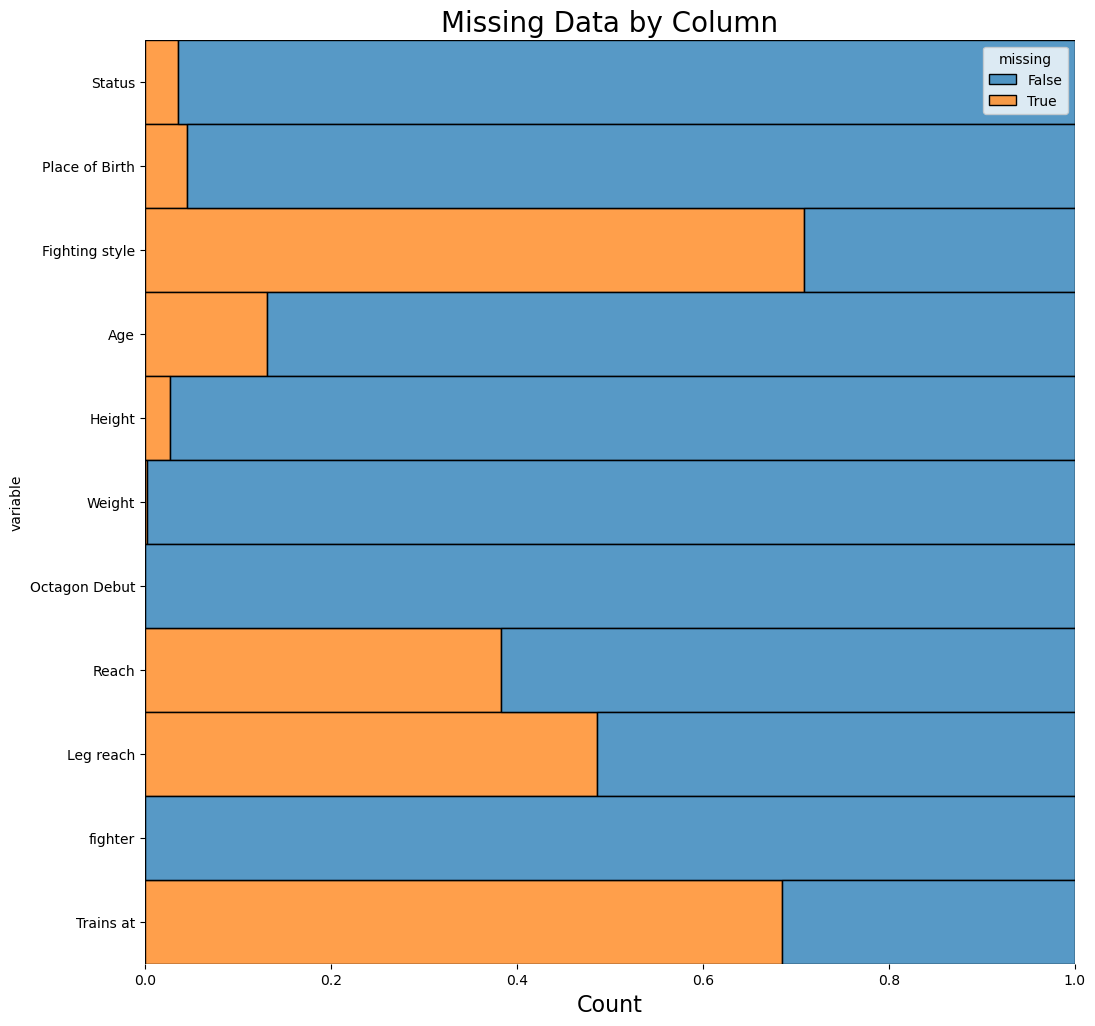

In [26]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fighter_bios.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

In [27]:
# What about only Active fighter Nans?
active = fighter_bios.loc[fighter_bios['Status'] == "Active"]
active

,Status,Place of Birth,Fighting style,Age,Height,Weight,Octagon Debut,Reach,Leg reach,fighter,Trains at
3,Active,"Houston, United States",Muay Thai,32.0,69.0,135.0,"May. 24, 2014",71.0,40.0,Aaron Phillips,Headkicks MMA
11,Active,"Rabat, Morocco",Striker,36.0,69.0,185.5,"Jul. 22, 2018",76.0,41.0,Abu Azaitar,NaN
12,Active,"Republic of Dagestan, Russia",NaN,33.0,71.0,170.5,"Nov. 09, 2019",72.0,39.5,Abubakar Nurmagomedov,NaN
13,Active,"Argun, Russia",MMA,32.0,74.0,186.0,"Sep. 03, 2022",78.0,43.0,Abus Magomedov,NaN
14,Active,"San Jose, United States",NaN,40.0,65.0,125.0,"Aug. 29, 2017",NaN,NaN,Adam Antolin,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2408,Active,"Irving, United States",Jiu-Jitsu,37.0,72.0,185.0,"Aug. 29, 2013",75.0,40.0,Zak Cummings,Glory MMA & Fitness
2411,Active,"Paris, France",MMA,38.0,68.0,147.0,"Oct. 05, 2019",72.0,42.0,Zarah Fairn,Olympia MMA
2413,Active,Kazakhstan,Freestyle,34.0,64.0,139.8,"Jul. 11, 2020",66.5,36.0,Zhalgas Zhumagulov,American Top Team
2415,Active,"Hebei, China",Muay Thai,33.0,64.0,114.8,"Aug. 04, 2018",63.0,36.0,Zhang Weili,NaN


Text(0.5, 0, 'Count')

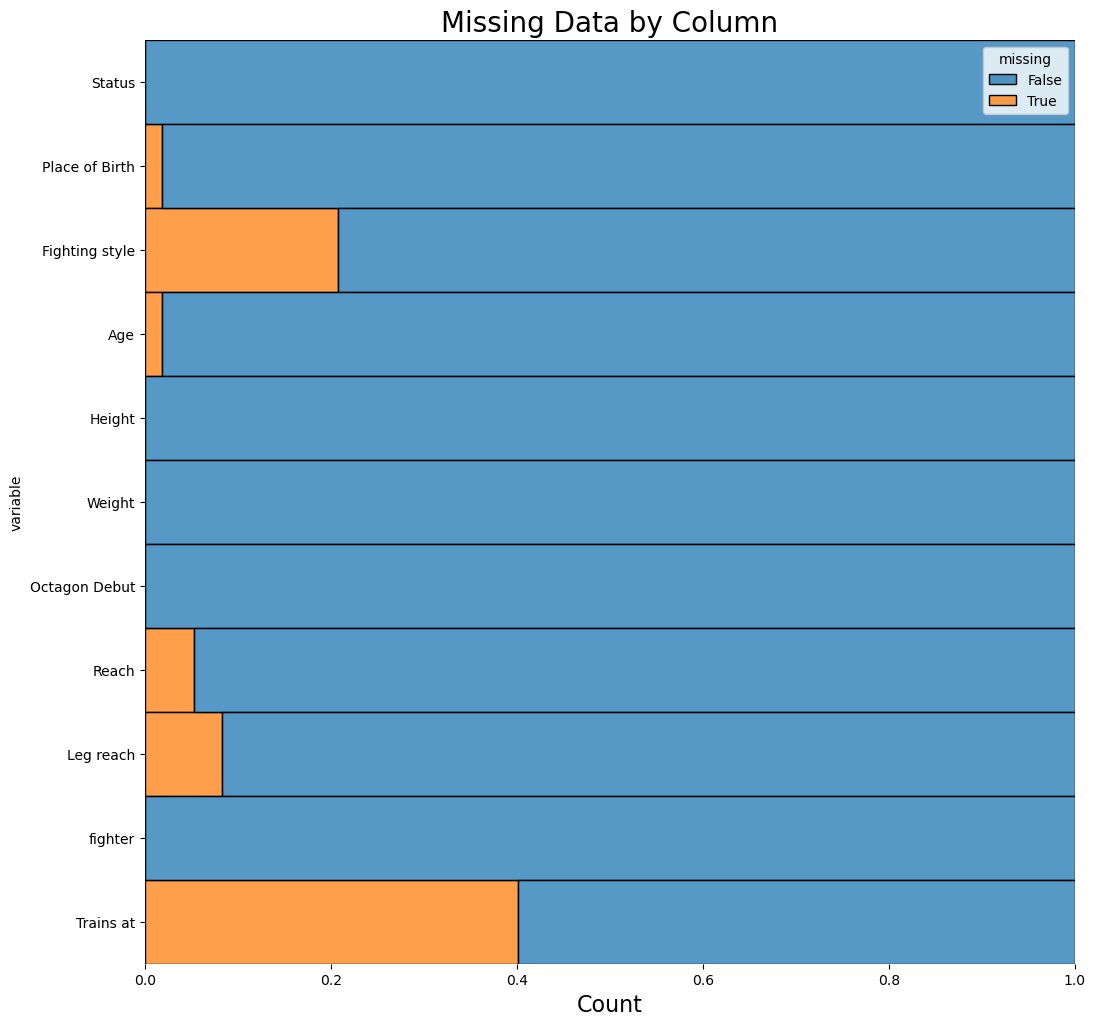

In [28]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = active.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

#### Dealing with Initial Missing Values

Initial missing values are those such as Age, Status, Fighting Style (categorical variables) which I can impute unknown categories to without much issue. The others (height, weight, reach, etc) must be dealt with after the merge.

In [29]:
# if missing place of birth, replace with 'Unknown'
fighter_bios['Place of Birth'].fillna('Unknown', inplace=True)

# if missing fighting style, replace with 'Unknown'
fighter_bios['Fighting style'].fillna('Unknown', inplace=True)

# if missing Trains at, replace with 'Unknown'
fighter_bios['Trains at'].fillna('Unknown', inplace=True)

# if missing status, replace with 'Unknown'
fighter_bios['Status'].fillna('Unknown', inplace=True)

# if missing age, replace with median
fighter_bios['Age'].fillna(fighter_bios['Age'].median(), inplace=True)

# if missing height, replace with median -- thankfully not many missing, as 
# this is a somewhat important feature
fighter_bios['Height'].fillna(fighter_bios['Height'].median(), inplace=True)

# if missing weight, replace with median -- thankfully not many missing
fighter_bios['Weight'].fillna(fighter_bios['Weight'].median(), inplace=True)

In [30]:
def get_bio_data(fighter, stat):
    try:
        data = fighter_bios[fighter_bios['fighter'] == fighter]
        d = data[stat].values[0]
        d = pd.to_numeric(d)
        return d
    except:
        return nan

In [31]:
# test
weight = get_bio_data('Khabib Nurmagomedov', 'Height')
weight

70.0

In [32]:
fights['A_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
fights['B_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
fights['Dif_Height'] = fights['A_Height'] - fights['B_Height']

In [33]:
fights['A_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
fights['B_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [34]:
fights['A_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg reach'), axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg reach'), axis=1)
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

<Axes: xlabel='Count', ylabel='variable'>

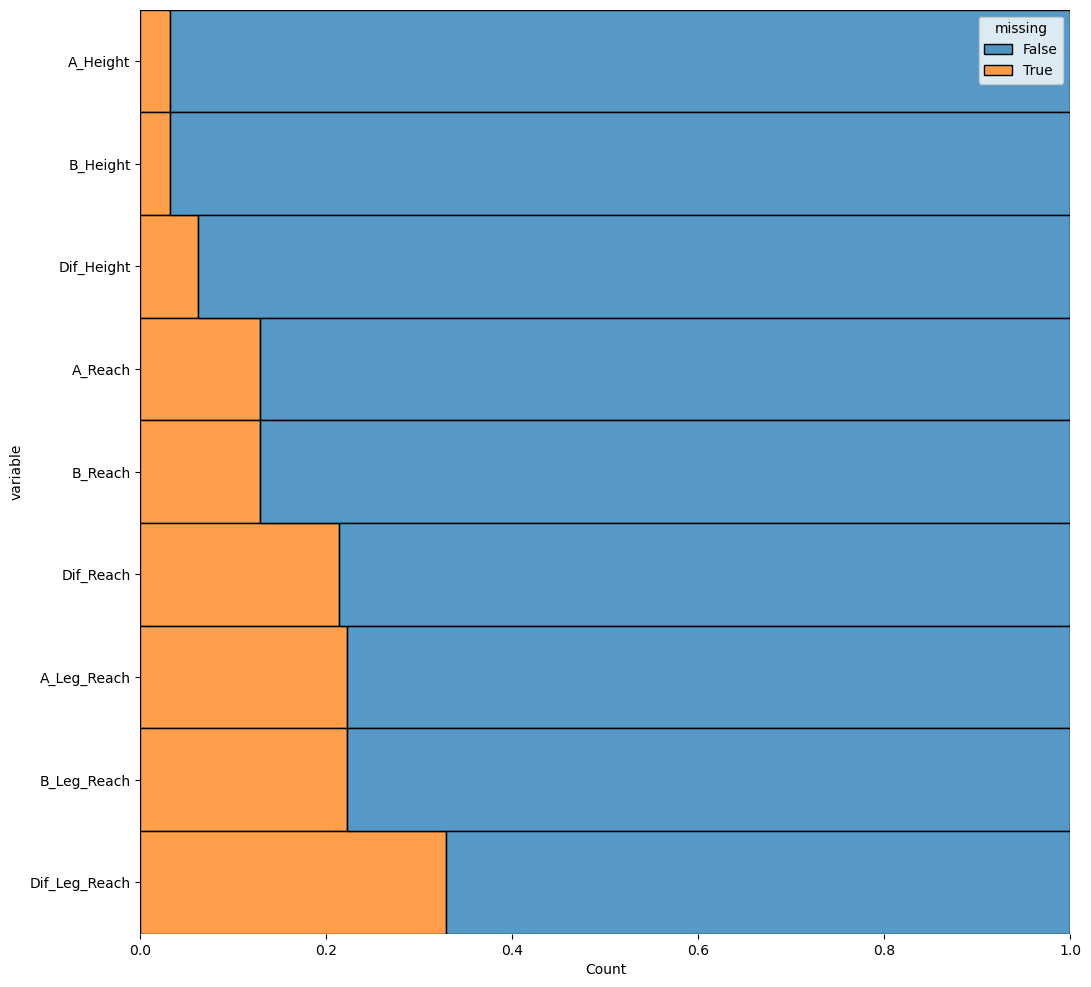

In [35]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [36]:
# drop rows missing height data
fights.dropna(subset=['A_Height', 'B_Height'], inplace=True)
len(fights)

8400

In [37]:
# New column indicating if we have the reach data for fighter A
fights['A_Reach_NA'] = fights['A_Reach'].isna()

# New column indicating if we have the reach data for fighter B
fights['B_Reach_NA'] = fights['B_Reach'].isna()

# New column indicating if we have the reach data for either fighter
fights['Reach_NA'] = fights['A_Reach_NA'] | fights['B_Reach_NA']

# New column indicating if we have leg reach data for fighter A
fights['A_Leg_Reach_NA'] = fights['A_Leg_Reach'].isna()

# New column indicating if we have leg reach data for fighter B
fights['B_Leg_Reach_NA'] = fights['B_Leg_Reach'].isna()

# New column indicating if we have leg reach data for either fighter
fights['Leg_Reach_NA'] = fights['A_Leg_Reach_NA'] | fights['B_Leg_Reach_NA']

### Add Weightclass

Then you can break down height, reach, etc... by weightclass, which is in the All_Events_Fights_and_FightUrls file

In [38]:
all_events = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [39]:
def find_typical_weightclass(fighter):
    try:
        data = all_events[all_events['Fighter1'] == fighter]
        data2 = all_events[all_events['Fighter2'] == fighter]
        data = pd.concat([data, data2])
        d = data['Weight class'].value_counts().index[0]
        return d
    except:
        return nan


In [40]:
# test
weight = find_typical_weightclass('Khabib Nurmagomedov')
weight

'Lightweight'

In [41]:
fights['A_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_A']), axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_B']), axis=1)

In [42]:
fights.head(3)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Leg_Reach,Dif_Leg_Reach,A_Reach_NA,B_Reach_NA,Reach_NA,A_Leg_Reach_NA,B_Leg_Reach_NA,Leg_Reach_NA,A_Typical_Weightclass,B_Typical_Weightclass
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,38.5,-0.5,False,False,False,False,False,False,Women's Bantamweight,Women's Bantamweight
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,40.0,4.0,False,False,False,False,False,False,Heavyweight,Heavyweight
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,NaN,NaN,False,False,False,False,True,True,Heavyweight,Heavyweight


In [43]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V6.csv', index=False)

In [44]:
# use fight_id to find weightclass of fight
def find_weightclass(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Weight class'].values[0]
        return d
    except:
        return nan

In [45]:
# test
weight = find_weightclass('ff6c8dab41efcc09')
weight

'Heavyweight'

In [46]:
fights['fight_weightclass'] = fights.apply(lambda row: find_weightclass(row['fight_id']), axis=1)

In [47]:
fights.head(3)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Dif_Leg_Reach,A_Reach_NA,B_Reach_NA,Reach_NA,A_Leg_Reach_NA,B_Leg_Reach_NA,Leg_Reach_NA,A_Typical_Weightclass,B_Typical_Weightclass,fight_weightclass
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,-0.5,False,False,False,False,False,False,Women's Bantamweight,Women's Bantamweight,Women's Bantamweight
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,4.0,False,False,False,False,False,False,Heavyweight,Heavyweight,Heavyweight
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,NaN,False,False,False,False,True,True,Heavyweight,Heavyweight,Heavyweight


In [48]:
fights['A_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['A_Typical_Weightclass'] == row['fight_weightclass'], axis=1)
fights['B_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['B_Typical_Weightclass'] == row['fight_weightclass'], axis=1)

In [49]:
fights.head(3)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Reach_NA,Reach_NA,A_Leg_Reach_NA,B_Leg_Reach_NA,Leg_Reach_NA,A_Typical_Weightclass,B_Typical_Weightclass,fight_weightclass,A_Fight_in_Typical_Weightclass,B_Fight_in_Typical_Weightclass
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,False,False,False,False,False,Women's Bantamweight,Women's Bantamweight,Women's Bantamweight,True,True
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,False,False,False,False,False,Heavyweight,Heavyweight,Heavyweight,True,True
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,False,False,False,True,True,Heavyweight,Heavyweight,Heavyweight,True,True


In [50]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V7.csv', index=False)

### Feature: Method

The main methods of fight finishing are:
- Decision (DEC)
- KO/TKO
- Submission (SUB)


In [51]:
all_events.head(2)

,Unnamed: 0.1,Unnamed: 0,W/L,Weight class,Method,Round,Time,Fighter1,Fighter2,F1_Kd,F2_Kd,F1_Str,F2_Str,F1_Td,F2_Td,F1_Sub,F2_Sub,fight_num,event_id,fight_link
0,0,0,win,Heavyweight,KO/TKO Punches,3,4:23,Ciryl Gane,Tai Tuivasa,1,1,110,29,0,0,0,0,1,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/810c9da0...
1,1,1,win,Middleweight,U-DEC,3,5:00,Robert Whittaker,Marvin Vettori,0,0,74,33,1,0,0,0,2,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/b8ca1acd...


In [52]:
# split Method into Method and Method Detail
all_events['Method_Primary'] = all_events['Method'].str.split('  ', expand=True)[0]
all_events['Method_Detail'] = all_events['Method'].str.split('  ', expand=True)[1]
all_events.head(3)

,Unnamed: 0.1,Unnamed: 0,W/L,Weight class,Method,Round,Time,Fighter1,Fighter2,F1_Kd,...,F2_Str,F1_Td,F2_Td,F1_Sub,F2_Sub,fight_num,event_id,fight_link,Method_Primary,Method_Detail
0,0,0,win,Heavyweight,KO/TKO Punches,3,4:23,Ciryl Gane,Tai Tuivasa,1,...,29,0,0,0,0,1,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/810c9da0...,KO/TKO,Punches
1,1,1,win,Middleweight,U-DEC,3,5:00,Robert Whittaker,Marvin Vettori,0,...,33,1,0,0,0,2,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/b8ca1acd...,U-DEC,None
2,2,2,win,Middleweight,U-DEC,3,5:00,Nassourdine Imavov,Joaquin Buckley,0,...,46,2,0,2,0,3,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/20f316f9...,U-DEC,None


In [53]:
def get_method(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Primary'].values[0]
        return d
    except:
        return nan

In [54]:
def get_details(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Detail'].values[0]
        return d
    except:
        return nan

In [55]:
# test
method = get_method('ff6c8dab41efcc09')
method

'U-DEC'

In [56]:
fights['InFightData__Method_Primary'] = fights.apply(lambda row: get_method(row['fight_id']), axis=1)
fights['InFightData__Method_Detail'] = fights.apply(lambda row: get_details(row['fight_id']), axis=1)

### Feature: Round & Time

In [57]:
def get_round_time(fight_id, round_or_time):
    try: 
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        if round_or_time == 'round':
            d = data['Round'].values[0]
        elif round_or_time == 'time':
            d = data['Time'].values[0]
        return d
    except:
        return nan

In [58]:
# test
round = get_round_time('ff6c8dab41efcc09', 'round')
round

3

In [59]:
fights['InFightData__Round'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'round'), axis=1)
fights['InFightData__Time'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'time'), axis=1)

In [60]:
fights.head(3)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Leg_Reach_NA,A_Typical_Weightclass,B_Typical_Weightclass,fight_weightclass,A_Fight_in_Typical_Weightclass,B_Fight_in_Typical_Weightclass,InFightData__Method_Primary,InFightData__Method_Detail,InFightData__Round,InFightData__Time
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,False,Women's Bantamweight,Women's Bantamweight,Women's Bantamweight,True,True,U-DEC,None,5,5:00
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,False,Heavyweight,Heavyweight,Heavyweight,True,True,Overturned,None,3,5:00
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,True,Heavyweight,Heavyweight,Heavyweight,True,True,KO/TKO,Punches,3,3:12


In [61]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V8.csv', index=False)

### Dealing with Remaining Missing Values

In [62]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

InFightData__Method_Detail    51.309524
Dif_Leg_Reach                 28.428571
A_Leg_Reach                   19.750000
B_Leg_Reach                   19.750000
Dif_Reach                     16.214286
A_Reach                       10.119048
B_Reach                       10.119048
B_Typical_Weightclass          0.095238
A_Typical_Weightclass          0.095238
dtype: float64

In [63]:
# replace nan values in "InFightData__Method_Detail" with "None"
fights['InFightData__Method_Detail'] = fights['InFightData__Method_Detail'].fillna('None')

In [64]:
# replace nan values in Typical Weightclass with current weightclass
fights['A_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['A_Typical_Weightclass']) else row['A_Typical_Weightclass'], axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['B_Typical_Weightclass']) else row['B_Typical_Weightclass'], axis=1)

In [65]:
# get median reach per height
reach_by_height = fights.groupby('A_Height')['A_Reach'].median()
reach_by_height

A_Height
0.0      NaN
60.0    60.0
61.0    62.0
61.5    62.0
62.0    64.0
62.5    62.5
63.0    64.5
63.5    65.5
64.0    65.0
64.5    68.0
65.0    66.0
66.0    67.0
66.5    66.0
67.0    69.0
67.5    69.0
68.0    70.0
68.5    71.0
69.0    71.0
70.0    72.0
70.5    76.0
71.0    73.0
71.5    73.0
72.0    74.0
72.5    78.0
73.0    75.0
73.5    77.0
74.0    75.5
74.5    78.0
75.0    77.0
75.5    76.0
76.0    80.0
77.0    79.0
78.0    81.0
78.5    79.0
79.0    80.0
80.0    80.0
84.0    84.5
Name: A_Reach, dtype: float64

In [66]:
# replace nan values in reach with median reach per height
fights['A_Reach'] = fights.apply(lambda row: reach_by_height[row['A_Height']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_height[row['B_Height']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

In [67]:
# get median leg reach per height
leg_reach_by_height = fights.groupby('A_Height')['A_Leg_Reach'].median()
leg_reach_by_height

A_Height
0.0      NaN
60.0    34.0
61.0    35.0
61.5    35.0
62.0    36.0
62.5    38.0
63.0    36.0
63.5    38.0
64.0    37.0
64.5    38.0
65.0    37.5
66.0    38.0
66.5    38.0
67.0    38.0
67.5    38.0
68.0    39.0
68.5    38.5
69.0    39.5
70.0    40.0
70.5    42.0
71.0    40.5
71.5    43.0
72.0    41.0
72.5    40.0
73.0    41.5
73.5    41.0
74.0    42.0
74.5    44.0
75.0    43.5
75.5    43.0
76.0    44.0
77.0    46.0
78.0    44.5
78.5    45.5
79.0    47.5
80.0     NaN
84.0    44.0
Name: A_Leg_Reach, dtype: float64

In [68]:
# replace nan values in leg reach with median leg reach per height
fights['A_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['A_Height']] if pd.isnull(row['A_Leg_Reach']) else row['A_Leg_Reach'], axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['B_Height']] if pd.isnull(row['B_Leg_Reach']) else row['B_Leg_Reach'], axis=1)

In [69]:
# recalculate leg reach dif and reach dif
fights['A_Leg_Reach_Dif'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['A_Reach_Dif'] = fights['A_Reach'] - fights['B_Reach']

In [70]:
fights.dtypes[-40:]

Dif_Rolling_Body_Strikes_att_std            float64
Dif_Rolling_Body_Strikes_percent_std        float64
Dif_Rolling_Leg_Strikes_land_std            float64
Dif_Rolling_Leg_Strikes_att_std             float64
Dif_Rolling_Leg_Strikes_percent_std         float64
Dif_Rolling_Distance_Strikes_land_std       float64
Dif_Rolling_Distance_Strikes_att_std        float64
Dif_Rolling_Distance_Strikes_percent_std    float64
Dif_Rolling_Clinch_Strikes_land_std         float64
Dif_Rolling_Clinch_Strikes_att_std          float64
Dif_Rolling_Clinch_Strikes_percent_std      float64
Dif_Rolling_Ground_Strikes_land_std         float64
Dif_Rolling_Ground_Strikes_att_std          float64
Dif_Rolling_Ground_Strikes_percent_std      float64
A_Height                                    float64
B_Height                                    float64
Dif_Height                                  float64
A_Reach                                     float64
B_Reach                                     float64
Dif_Reach   

In [71]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

Dif_Leg_Reach      28.428571
Dif_Reach          16.214286
A_Leg_Reach_Dif     0.690476
A_Reach_Dif         0.619048
A_Leg_Reach         0.357143
B_Leg_Reach         0.357143
A_Reach             0.321429
B_Reach             0.321429
dtype: float64

In [72]:
# get median reach per weightclass
reach_by_weightclass = fights.groupby('fight_weightclass')['A_Reach'].median()
reach_by_weightclass

fight_weightclass
Bantamweight             69.00
Catch Weight             71.00
Featherweight            71.00
Flyweight                66.00
Heavyweight              78.00
Light Heavyweight        76.00
Lightweight              71.00
Middleweight             75.00
Welterweight             74.00
Women's Bantamweight     67.50
Women's Featherweight    68.50
Women's Flyweight        66.25
Women's Strawweight      64.00
Name: A_Reach, dtype: float64

In [73]:
# get median height per weightclass
height_by_weightclass = fights.groupby('fight_weightclass')['A_Height'].median()
height_by_weightclass

fight_weightclass
Bantamweight             67.00
Catch Weight             70.00
Featherweight            69.00
Flyweight                65.00
Heavyweight              75.00
Light Heavyweight        74.00
Lightweight              70.00
Middleweight             73.00
Welterweight             71.25
Women's Bantamweight     66.00
Women's Featherweight    67.00
Women's Flyweight        66.00
Women's Strawweight      64.00
Name: A_Height, dtype: float64

In [74]:
# replace nan values in "A_Reach" with median for weight class
fights['A_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

# replace nan values in "A_Height" with median for weight class
fights['A_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Height']) else row['A_Height'], axis=1)
fights['B_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Height']) else row['B_Height'], axis=1)


In [75]:
# Once again, re-run the Difs
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [76]:
# get missing
missing_values = fights.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(fights) * 100
missing_values

Dif_Leg_Reach      0.690476
A_Leg_Reach_Dif    0.690476
A_Reach_Dif        0.619048
B_Leg_Reach        0.357143
A_Leg_Reach        0.357143
dtype: float64

In [77]:
# drop nan values
fights = fights.dropna()


In [78]:
# drop A_Reach_Dif and A_Leg_Reach_Dif
fights = fights.drop(['A_Reach_Dif', 'A_Leg_Reach_Dif'], axis=1)

### Feature: Size Ratios

In [79]:
fights['A_Ape_Index'] = fights['A_Reach'] / fights['A_Height']
fights['B_Ape_Index'] = fights['B_Reach'] / fights['B_Height']

# Leg_Index = Leg_Reach / Height
fights['A_Leg_Index'] = fights['A_Leg_Reach'] / fights['A_Height']
fights['B_Leg_Index'] = fights['B_Leg_Reach'] / fights['B_Height']

# Leg_to_Wing_Index = Leg_Reach / Reach
fights['A_Leg_to_Wing_Index'] = fights['A_Leg_Reach'] / fights['A_Reach']
fights['B_Leg_to_Wing_Index'] = fights['B_Leg_Reach'] / fights['B_Reach']

In [80]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V9.csv', index=False)

### Feature: Winner

In [81]:
# split Winner columns by " 
fights['Winner'] = fights['Winner'].str.split('"').str[0].str.strip()
fights.head(2)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,InFightData__Method_Primary,InFightData__Method_Detail,InFightData__Round,InFightData__Time,A_Ape_Index,B_Ape_Index,A_Leg_Index,B_Leg_Index,A_Leg_to_Wing_Index,B_Leg_to_Wing_Index
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,U-DEC,None,5,5:00,1.014706,0.992754,0.558824,0.557971,0.550725,0.562044
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,Overturned,None,3,5:00,1.038961,1.006944,0.571429,0.555556,0.550000,0.551724


In [82]:
# add column "win?", if column winner is equal to fighter_A
fights['win?'] = fights.apply(lambda row: 1 if row['Winner'] == row['Fighter_A'] else 0, axis=1)
fights.head(30)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,InFightData__Method_Detail,InFightData__Round,InFightData__Time,A_Ape_Index,B_Ape_Index,A_Leg_Index,B_Leg_Index,A_Leg_to_Wing_Index,B_Leg_to_Wing_Index,win?
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,None,5,5:00,1.014706,0.992754,0.558824,0.557971,0.550725,0.562044,1
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,None,3,5:00,1.038961,1.006944,0.571429,0.555556,0.550000,0.551724,0
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,Punches,3,3:12,1.013514,1.027397,0.554054,0.568493,0.546667,0.553333,1
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,Punch,1,4:13,1.052632,1.005952,0.585526,0.523810,0.556250,0.520710,1
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,None,3,5:00,1.020548,1.000000,0.575342,0.557143,0.563758,0.557143,1
5,5,Matt Brown,Jordan Mein,0,1,40,84,24,58,0.47,...,Elbows,2,1:00,1.041667,1.013889,0.597222,0.569444,0.573333,0.561644,1
6,6,Beneil Dariush,Rashid Magomedov,0,0,60,120,41,78,0.50,...,None,3,5:00,1.028571,1.021739,0.578571,0.572464,0.562500,0.560284,1
7,7,Andy Ogle,Cole Miller,0,0,27,51,21,40,0.52,...,None,3,5:00,1.014706,1.013699,0.573529,0.561644,0.565217,0.554054,0
8,8,Urijah Faber,Michael McDonald,1,0,29,46,9,27,0.63,...,Guillotine Choke,2,3:22,1.015152,1.014493,0.560606,0.565217,0.552239,0.557143,1
10,10,Li Jingliang,Dhiego Lima,1,0,13,39,6,16,0.33,...,Punches,1,1:25,0.993056,1.013514,0.562500,0.574324,0.566434,0.566667,1


In [83]:
# check number of wins vs losses
fights['win?'].value_counts()

1    4171
0    4171
Name: win?, dtype: int64

In [84]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V10.csv', index=False)

### Feature: Favorite

In [85]:
# get columns in fight df with odds in the name
odds_columns = [col for col in fights.columns if 'Odds' in col]
odds_columns

['Fighter_A_Odds',
 'Fighter_B_Odds',
 'Fighter_A_Odds_Change',
 'Fighter_B_Odds_Change',
 'Dif_Odds']

In [86]:
fights['favorite?'] = np.where(fights['Fighter_A_Odds'] < fights['Fighter_B_Odds'], 1, 0)
fights['favorite?'].value_counts()

0    4244
1    4098
Name: favorite?, dtype: int64

In [87]:
fight_check_cols = ['Fighter_A', 'Fighter_B', 'Winner', 'win?', 'Fighter_A_Odds', 'Fighter_B_Odds','favorite?']
fights[fight_check_cols].head(30)

,Fighter_A,Fighter_B,Winner,win?,Fighter_A_Odds,Fighter_B_Odds,favorite?
0,Holly Holm,Irene Aldana,Holly Holm,1,-125.0,105.0,1
1,Greg Hardy,Ben Sosoli,Ben Sosoli,0,-400.0,325.0,1
2,Jared Rosholt,Josh Copeland,Jared Rosholt,1,-310.0,280.0,1
3,Alistair Overeem,Stefan Struve,Alistair Overeem,1,-200.0,185.0,1
4,Nordine Taleb,Kyle Prepolec,Nordine Taleb,1,-420.0,335.0,1
5,Matt Brown,Jordan Mein,Matt Brown,1,290.0,-320.0,0
6,Beneil Dariush,Rashid Magomedov,Beneil Dariush,1,-115.0,-105.0,1
7,Andy Ogle,Cole Miller,Cole Miller,0,185.0,-200.0,0
8,Urijah Faber,Michael McDonald,Urijah Faber,1,-150.0,130.0,1
10,Li Jingliang,Dhiego Lima,Li Jingliang,1,130.0,-140.0,0


In [88]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V11.csv', index=False)

In [89]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V11.csv')

In [90]:
fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,InFightData__Round,InFightData__Time,A_Ape_Index,B_Ape_Index,A_Leg_Index,B_Leg_Index,A_Leg_to_Wing_Index,B_Leg_to_Wing_Index,win?,favorite?
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,5,5:00,1.014706,0.992754,0.558824,0.557971,0.550725,0.562044,1,1
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,3,5:00,1.038961,1.006944,0.571429,0.555556,0.550000,0.551724,0,1
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,3,3:12,1.013514,1.027397,0.554054,0.568493,0.546667,0.553333,1,1
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,1,4:13,1.052632,1.005952,0.585526,0.523810,0.556250,0.520710,1,1
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,3,5:00,1.020548,1.000000,0.575342,0.557143,0.563758,0.557143,1,1


### Features: Win/Loss Details

In [91]:
# get columns with date in the name
date_columns = [col for col in fights.columns if 'date' in col]
date_columns

['date']

In [92]:
# add a formatted date column
fights['datetime'] = pd.to_datetime(fights['date'])
fights['date_formatted'] = fights['datetime'].dt.date

In [93]:
fights

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_Ape_Index,B_Ape_Index,A_Leg_Index,B_Leg_Index,A_Leg_to_Wing_Index,B_Leg_to_Wing_Index,win?,favorite?,datetime,date_formatted
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,1.014706,0.992754,0.558824,0.557971,0.550725,0.562044,1,1,2020-10-03,2020-10-03
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,1.038961,1.006944,0.571429,0.555556,0.550000,0.551724,0,1,2019-10-18,2019-10-18
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,1.013514,1.027397,0.554054,0.568493,0.546667,0.553333,1,1,2015-03-14,2015-03-14
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,1.052632,1.005952,0.585526,0.523810,0.556250,0.520710,1,1,2014-12-13,2014-12-13
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,1.020548,1.000000,0.575342,0.557143,0.563758,0.557143,1,1,2019-05-04,2019-05-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8337,8947,Marcus Davis,Mike Swick,0,0,31,55,32,86,0.56,...,1.000000,1.027397,0.571429,0.568493,0.571429,0.553333,0,0,2008-06-07,2008-06-07
8338,8948,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,...,1.000000,1.014286,0.569444,0.557143,0.569444,0.549296,0,0,2014-10-25,2014-10-25
8339,8949,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,...,1.054795,1.041096,0.561644,0.568493,0.532468,0.546053,0,0,2021-05-01,2021-05-01
8340,8950,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,...,1.028986,1.077465,0.565217,0.570423,0.549296,0.529412,0,0,2015-02-28,2015-02-28


In [94]:
def get_number_UFC_fights(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data)


In [95]:
get_number_UFC_fights('Conor McGregor', '2020-01-01')

10

In [96]:
fights['A_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Total_UFC_Fights'] = fights['A_Total_UFC_Fights'] - fights['B_Total_UFC_Fights']

In [97]:
fights.head(3)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Leg_Index,A_Leg_to_Wing_Index,B_Leg_to_Wing_Index,win?,favorite?,datetime,date_formatted,A_Total_UFC_Fights,B_Total_UFC_Fights,Dif_Total_UFC_Fights
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.557971,0.550725,0.562044,1,1,2020-10-03,2020-10-03,9,7,2
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.555556,0.550000,0.551724,0,1,2019-10-18,2019-10-18,3,0,3
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,0.568493,0.546667,0.553333,1,1,2015-03-14,2015-03-14,2,1,1


#### Wins

In [98]:
# add number of wins
def get_number_UFC_wins(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['win?'].sum()

In [99]:
fights['A_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Wins'] = fights['A_UFC_Wins'] - fights['B_UFC_Wins']

#### Losses

In [100]:
def get_number_UFC_losses(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data) - data['win?'].sum()

In [101]:
fights['A_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Losses'] = fights['A_UFC_Losses'] - fights['B_UFC_Losses']

#### W/L Percentages

In [102]:
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Wins'] / fights['A_Total_UFC_Fights']
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Wins'] / fights['B_Total_UFC_Fights']

# nans to 0
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'].fillna(0)
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Win_Percentage'].fillna(0)


# add diff
fights['Dif_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'] - fights['B_UFC_Win_Percentage']

### Last 5

#### Last 5 Win Percentage

In [103]:
def get_last5_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(5)
    return data['win?'].sum() / len(data)

In [104]:
fights['A_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'].fillna(0)
fights['B_Last5_Win_Percentage'] = fights['B_Last5_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'] - fights['B_Last5_Win_Percentage']

#### Last 3 Win Percentage

In [105]:
def get_last3_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(3)
    return data['win?'].sum() / len(data)

In [106]:
fights['A_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'].fillna(0)
fights['B_Last3_Win_Percentage'] = fights['B_Last3_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'] - fights['B_Last3_Win_Percentage']

### Win_by / Loss_by Features

In [107]:

fights['InFightData__Method_Primary'].value_counts()

U-DEC         3072
KO/TKO        2654
SUB           1524
S-DEC          896
M-DEC           82
Overturned      64
CNC             30
DQ              18
Other            2
Name: InFightData__Method_Primary, dtype: int64

In [108]:
def get_general_method(fight_method):
    if 'DEC' in fight_method:
        return 'DEC'
    elif 'SUB' in fight_method:
        return 'SUB'
    elif 'KO' in fight_method:
        return 'KO'
    else:
        return 'OTHER'

In [109]:
# make general method column
fights['InFightData__General_Method'] = fights['InFightData__Method_Primary'].apply(lambda x: get_general_method(x))

In [110]:
fights.head(2)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_UFC_Win_Percentage,B_UFC_Win_Percentage,Dif_UFC_Win_Percentage,A_Last5_Win_Percentage,B_Last5_Win_Percentage,Dif_Last5_Win_Percentage,A_Last3_Win_Percentage,B_Last3_Win_Percentage,Dif_Last3_Win_Percentage,InFightData__General_Method
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.666667,0.571429,0.095238,0.600000,0.8,-0.200000,0.666667,0.666667,0.000000,DEC
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.666667,0.000000,0.666667,0.666667,0.0,0.666667,0.666667,0.000000,0.666667,OTHER


In [111]:
def get_win_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

def get_loss_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

In [112]:
fights['A_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'].fillna(0)
fights['B_Win_By_KO_Percentage'] = fights['B_Win_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'] - fights['B_Win_By_KO_Percentage']

In [113]:
fights['A_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'].fillna(0)
fights['B_Loss_By_KO_Percentage'] = fights['B_Loss_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'] - fights['B_Loss_By_KO_Percentage']

#### Win/Loss by DEC

In [114]:
def get_win_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

def get_loss_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

In [115]:
fights['A_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'].fillna(0)
fights['B_Win_By_Decision_Percentage'] = fights['B_Win_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'] - fights['B_Win_By_Decision_Percentage']

In [116]:
fights['A_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'].fillna(0)
fights['B_Loss_By_Decision_Percentage'] = fights['B_Loss_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'] - fights['B_Loss_By_Decision_Percentage']

In [117]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V12.csv', index=False)

### Round & Time Statistics

In [118]:
# find round columns
round_cols = [col for col in fights.columns if 'Round' in col]
round_cols

['InFightData__Round']

In [119]:
time_cols = [col for col in fights.columns if 'Time' in col]
time_cols

['InFightData__Time']

In [120]:
fights.InFightData__Round.dtypes

dtype('int64')

In [121]:
fights.InFightData__Time

0       5:00
1       5:00
2       3:12
3       4:13
4       5:00
        ... 
8337    5:00
8338    5:00
8339    5:00
8340    2:37
8341    2:56
Name: InFightData__Time, Length: 8342, dtype: object

In [122]:
# convert time to seconds
fights['final_round_seconds'] = fights.InFightData__Time.apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [123]:
fights['InFightData__Total_Fight_Time_Seconds'] = (fights['InFightData__Round'] - 1) * 5 * 60 + fights['final_round_seconds']

#### Career Fight Time

In [124]:
def get_career_fight_time_seconds(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['InFightData__Total_Fight_Time_Seconds'].sum()

In [125]:
fights['A_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Fight_Time_Seconds'] = fights['A_UFC_Fight_Time_Seconds'] - fights['B_UFC_Fight_Time_Seconds']

### Fix NANs

In [126]:
missing = fights.isna().sum()
missing[missing > 0]
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [127]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V13.csv', index=False)

### Stats / Round Features

For these, use 1) Top down, and 2) Opponent averages

In [128]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V13.csv')

In [129]:
topdown_cols = [n for n in fights.columns.to_list() if 'topdown' in n]
# A TOPDOWN
a_topdown_cols = [n for n in topdown_cols if n.startswith('A_')]
# get rid of any percent columns
a_topdown_cols = [n for n in a_topdown_cols if 'percent' not in n]

# B TOPDOWN
b_topdown_cols = [n for n in topdown_cols if n.startswith('B_')]
# get rid of any percent columns
b_topdown_cols = [n for n in b_topdown_cols if 'percent' not in n]


In [130]:
fights.head(2)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Win_By_Decision_Percentage,Dif_Win_By_Decision_Percentage,A_Loss_By_Decision_Percentage,B_Loss_By_Decision_Percentage,Dif_Loss_By_Decision_Percentage,final_round_seconds,InFightData__Total_Fight_Time_Seconds,A_UFC_Fight_Time_Seconds,B_UFC_Fight_Time_Seconds,Dif_UFC_Fight_Time_Seconds
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.571429,0.095238,0.666667,0.571429,0.095238,300,1500,7788,5595,2193
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.000000,0.666667,0.666667,0.000000,0.666667,300,900,628,0,628


In [131]:
# use A_UFC_Fight_Time_Seconds to deduce total number of rounds
# 5 minutes per round
# get total number of rounds in ufc
fights['A_UFC_Fight_Rounds'] = fights['A_UFC_Fight_Time_Seconds'] / 300
fights['B_UFC_Fight_Rounds'] = fights['B_UFC_Fight_Time_Seconds'] / 300

In [132]:
# add per-round averages using topdown columns
for col in a_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']

In [133]:
fights.head(2)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_topdown_Avg_Body_Strikes_land_per_round,B_topdown_Avg_Body_Strikes_att_per_round,B_topdown_Avg_Leg_Strikes_land_per_round,B_topdown_Avg_Leg_Strikes_att_per_round,B_topdown_Avg_Distance_Strikes_land_per_round,B_topdown_Avg_Distance_Strikes_att_per_round,B_topdown_Avg_Clinch_Strikes_land_per_round,B_topdown_Avg_Clinch_Strikes_att_per_round,B_topdown_Avg_Ground_Strikes_land_per_round,B_topdown_Avg_Ground_Strikes_att_per_round
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,0.596515,1.065684,0.743968,1.005362,3.733244,10.636729,0.241287,0.341823,0.160858,0.214477
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,inf,inf,inf,inf,inf,inf,NaN,inf,NaN,NaN


In [134]:
fights.columns.to_list()

['Unnamed: 0',
 'Fighter_A',
 'Fighter_B',
 'A_Kd',
 'B_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'B_Sig_strike_land',
 'B_Sig_strike_att',
 'A_Sig_strike_percent',
 'B_Sig_strike_percent',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'B_Total_Strikes_land',
 'B_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'B_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'B_Takedowns_land',
 'B_Takedowns_att',
 'A_Takedown_percent',
 'B_Takedown_percent',
 'A_Sub_Attempts_land',
 'A_Sub_Attempts_att',
 'B_Sub_Attempts_land',
 'B_Sub_Attempts_att',
 'A_Sub_Success_Percent',
 'B_Sub_Success_Percent',
 'A_Rev',
 'B_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'B_Ctrl_time_min',
 'B_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'B_Ctrl_time_tot',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'fight_id',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'B_Head_Strikes_land',
 'B_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'B_Head_Strikes_percent',
 'A_Body_Str

In [135]:
# get opponent average columns
opp_avg_cols = [n for n in fights.columns.to_list() if 'Opp_Avg' in n]
# A OPP AVG
a_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('A_')]
# get rid of any percent columns
a_opp_avg_cols = [n for n in a_opp_avg_cols if 'percent' not in n]

# B OPP AVG
b_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('B_')]
# get rid of any percent columns
b_opp_avg_cols = [n for n in b_opp_avg_cols if 'percent' not in n]

b_opp_avg_cols

['B_Opp_Avg_Kd',
 'B_Opp_Avg_Sig_strike_land',
 'B_Opp_Avg_Sig_strike_att',
 'B_Opp_Avg_Total_Strikes_land',
 'B_Opp_Avg_Total_Strikes_att',
 'B_Opp_Avg_Takedowns_land',
 'B_Opp_Avg_Takedowns_att',
 'B_Opp_Avg_Sub_Attempts_land',
 'B_Opp_Avg_Sub_Attempts_att',
 'B_Opp_Avg_Sub_Success_Percent',
 'B_Opp_Avg_Rev',
 'B_Opp_Avg_Ctrl_time_min',
 'B_Opp_Avg_Ctrl_time_sec',
 'B_Opp_Avg_Ctrl_time_tot',
 'B_Opp_Avg_Head_Strikes_land',
 'B_Opp_Avg_Head_Strikes_att',
 'B_Opp_Avg_Body_Strikes_land',
 'B_Opp_Avg_Body_Strikes_att',
 'B_Opp_Avg_Leg_Strikes_land',
 'B_Opp_Avg_Leg_Strikes_att',
 'B_Opp_Avg_Distance_Strikes_land',
 'B_Opp_Avg_Distance_Strikes_att',
 'B_Opp_Avg_Clinch_Strikes_land',
 'B_Opp_Avg_Clinch_Strikes_att',
 'B_Opp_Avg_Ground_Strikes_land',
 'B_Opp_Avg_Ground_Strikes_att']

In [136]:
# add per-round averages using opponent averages
for col in a_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']


#### Add Per-Round Difs

In [137]:
# add difference in per-round averages

# get per-round topdown columns
topdown_per_round_cols = [n for n in fights.columns.to_list() if 'topdown' and 'per_round' in n]

topdown_per_round_cols = pd.DataFrame(topdown_per_round_cols)
topdown_per_round_cols.columns = ['col']
topdown_per_round_cols['non-specific'] = topdown_per_round_cols['col'].str[2:]
# get unique values
topdown_per_round_cols = topdown_per_round_cols['non-specific'].unique().tolist()

In [138]:
topdown_per_round_cols

['topdown_Avg_Kd_per_round',
 'topdown_Avg_Sig_strike_land_per_round',
 'topdown_Avg_Sig_strike_att_per_round',
 'topdown_Avg_Total_Strikes_land_per_round',
 'topdown_Avg_Total_Strikes_att_per_round',
 'topdown_Avg_Takedowns_land_per_round',
 'topdown_Avg_Takedowns_att_per_round',
 'topdown_Avg_Sub_Attempts_land_per_round',
 'topdown_Avg_Sub_Attempts_att_per_round',
 'topdown_Avg_Sub_Success_Percent_per_round',
 'topdown_Avg_Rev_per_round',
 'topdown_Avg_Ctrl_time_min_per_round',
 'topdown_Avg_Ctrl_time_sec_per_round',
 'topdown_Avg_Ctrl_time_tot_per_round',
 'topdown_Avg_Head_Strikes_land_per_round',
 'topdown_Avg_Head_Strikes_att_per_round',
 'topdown_Avg_Body_Strikes_land_per_round',
 'topdown_Avg_Body_Strikes_att_per_round',
 'topdown_Avg_Leg_Strikes_land_per_round',
 'topdown_Avg_Leg_Strikes_att_per_round',
 'topdown_Avg_Distance_Strikes_land_per_round',
 'topdown_Avg_Distance_Strikes_att_per_round',
 'topdown_Avg_Clinch_Strikes_land_per_round',
 'topdown_Avg_Clinch_Strikes_att_pe

In [139]:
for col in topdown_per_round_cols:
    fights[f'Dif_{col}'] = fights[f'A_{col}'] - fights[f'B_{col}']

In [140]:
fights.head(2)

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,Dif_Opp_Avg_Body_Strikes_land_per_round,Dif_Opp_Avg_Body_Strikes_att_per_round,Dif_Opp_Avg_Leg_Strikes_land_per_round,Dif_Opp_Avg_Leg_Strikes_att_per_round,Dif_Opp_Avg_Distance_Strikes_land_per_round,Dif_Opp_Avg_Distance_Strikes_att_per_round,Dif_Opp_Avg_Clinch_Strikes_land_per_round,Dif_Opp_Avg_Clinch_Strikes_att_per_round,Dif_Opp_Avg_Ground_Strikes_land_per_round,Dif_Opp_Avg_Ground_Strikes_att_per_round
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,-0.508189,-0.916898,-0.421269,-0.402786,-2.884099,-7.162099,0.179903,0.123673,-0.145549,-0.321364
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,NaN,NaN


In [141]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V14.csv', index=False)

4/5/23 -- Adding Fighter Training History

In [142]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V14.csv')

In [143]:
all_fighter_training_history = pd.read_csv('data/final/aggregates/All_Fighter_Training_History_Fixed_V2.csv')
all_fighter_training_history.head(2)

,Fighter_Name,Martial_Arts_1,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_9,...,Instructor_14,Year_Started_15,Gym_15,Instructor_15,Year_Started_16,Gym_16,Instructor_16,Year_Started_17,Gym_17,Instructor_17
0,Aalon Cruz,Krav Maga,Muay Thai,Brazilian Jiu-Jitsu,Judo,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Brink,NaN,Krav Maga,Muay Thai,Brazilian Jiu-Jitsu,Judo,Sambo,Wrestling,Mixed Martial Arts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# rename Martial_Arts_1 to MA_1
all_fighter_training_history = all_fighter_training_history.rename(columns={'Martial_Arts_1': 'MA_1'})

In [145]:
# strip all values
all_fighter_training_history = all_fighter_training_history.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [146]:

# Function to shift martial arts columns when Martial_Arts_1 is NaN
def shift_martial_arts_columns(row):
    ma_columns = [f'MA_{i}' for i in range(1, 17)]  # Adjust the range according to the number of martial arts columns
    ma_values = row[ma_columns]
    instructor_columns = [f'Instructor_{i}' for i in range(1, 17)]  # Adjust the range according to the number of instructor columns
    instructor_values = row[instructor_columns]
    year_started_columns = [f'Year_Started_{i}' for i in range(1, 17)]  # Adjust the range according to the number of year started columns
    year_started_values = row[year_started_columns]


    # Shift the values if Martial_Arts_1 is NaN
    if pd.isna(row['MA_1']):
        ma_values = ma_values.shift(-1)
        instructor_values = instructor_values.shift(-1)
        year_started_values = year_started_values.shift(-1)

    row[ma_columns] = ma_values
    row[instructor_columns] = instructor_values
    row[year_started_columns] = year_started_values
    return row

# Apply the function to the dataframe
df = all_fighter_training_history.apply(shift_martial_arts_columns, axis=1)
print(df)

            Fighter_Name       MA_1       MA_2                 MA_3  \
0             Aalon Cruz  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
1            Aaron Brink  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
2         Aaron Phillips     Karate  Muay Thai  Brazilian Jiu-Jitsu   
3            Aaron Riley     Karate  Muay Thai  Brazilian Jiu-Jitsu   
4             Aaron Rosa  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
...                  ...        ...        ...                  ...   
2152  Zhalgas Zhumagulov    Kung Fu  Muay Thai  Brazilian Jiu-Jitsu   
2153        Zhang Lipeng    Kung Fu      Sanda            Taekwondo   
2154         Zhang Weili    Kung Fu      Sanda            Muay Thai   
2155    Zubaira Tukhugov  Muay Thai      Sambo                  MMA   
2156    Zviad Lazishvili     Karate       Judo               Aikido   

                     MA_4                 MA_5                 MA_6  \
0                    Judo                  NaN                  NaN   
1    

In [147]:
def get_martial_art_history(fighter, ma_number, ret='martial_art'):
    try:
        data = df[df['Fighter_Name'] == fighter]
        
        # Get martial art, instructor, and year started for the specified martial art number
        ma = data[f'MA_{ma_number}'].values[0]
        instructor = data[f'Instructor_{ma_number}'].values[0]
        year_started = data[f'Year_Started_{ma_number}'].values[0]
        
        if ret == 'martial_art':
            return ma
        elif ret == 'instructor':
            return instructor
        elif ret == 'year_started':
            return year_started
        elif ret == 'all':
            return ma, instructor, year_started
        else: 
            return None
    except:
        print(f"Error with {str(fighter)} and {str(ma_number)})")
        return np.nan, np.nan, np.nan

In [148]:
get_martial_art_history('Amanda Nunes', 1, 'martial_art')


'Brazilian Jiu-Jitsu'

In [149]:
# add initial martial art to each fighter
fights['A_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'martial_art'), axis=1)
fights['B_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'martial_art'), axis=1)
fights['B_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'martial_art'), axis=1)
fights['B_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'year_started'), axis=1)


Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Cameron Saaiman and 1)
Error with Gabriel Bonfim and 1)
Error with Ismael Bonfim and 1)
Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Alexander Yakovlev and 1)
Error with Tamires Vidal and 1)
Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Francis Marshall and 1)
Error with Kai Kara-France and 1)
Error with Alexander Yakovlev and 1)
Error with Daniel Marcos and 1)
Error with Ashlee Evans-Smith and 1)
Error with Tereza Bleda and 1)
Error with Kai Kara-France and 1)
Error with Rhys McKee and 1)
Error with Brunno Ferreira and 1)
Error with Steven Koslow and 1)
Error with Ashlee Evans-Smith and 1)
Error with Ashlee Evans-Smith and 1)
Error with Alexander Yakovlev and 1)
Error with Melquizael Costa and 1)
Error with Ashlee Evans-Smith and 1)
Error with Lucas Alexander and 1)
Error with Rhys McKee and 1)
Error with Alessandro Costa and 1)
Err

In [150]:
fights

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_Martial_Art_Instructor_2,B_Martial_Art_Instructor_2,A_Martial_Art_Year_Started_2,B_Martial_Art_Year_Started_2,A_Martial_Art_3,B_Martial_Art_3,A_Martial_Art_Instructor_3,B_Martial_Art_Instructor_3,A_Martial_Art_Year_Started_3,B_Martial_Art_Year_Started_3
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,Mike Winkeljohn,Instructor: Juan Carlos,1993,2009,Muay Thai,Brazilian Jiu-Jitsu,Mike Winkeljohn,Instructor: Gustavo Dantas,2001,2012
1,1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,Din Thomas,John Wayne Parr,2011,2012,Boxing,Boxing,Din Thomas,John Wayne Parr,2012,2013
2,2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,Coach Bobby Douglas,John Smith,2003,2013,Brazilian Jiu-Jitsu,Brazilian Jiu-Jitsu,Professor Jason Tooke,Carlos Gracie Jr.,2007,2016
3,3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,...,Thom Harinck,Ramon Dekkers,1999,2006,Brazilian Jiu-Jitsu,Brazilian Jiu-Jitsu,Rudimar Fedrigo,Robson Moura,2002,2008
4,4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,...,Firas Zahabi,Kru Yodtong Senanan,2003,2011,Wrestling,Brazilian Jiu Jitsu,Firas Zahabi,Professor Rodrigo Medeiros,2004,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8337,8947,Marcus Davis,Mike Swick,0,0,31,55,32,86,0.56,...,Kru Yodtong,Kru Yodtong,2004,2001,Brazilian Jiu-Jitsu,Brazilian Jiu-Jitsu,Professor Carlos Gracie Jr.,Cesar Gracie,2006,2003
8338,8948,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,...,Joe Smith,Matt Lindland,2014,2004,Brazilian Jiu-Jitsu,Wrestling,Carlos Gracie Jr.,Matt Lindland,2016,2004
8339,8949,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,...,Pawel Jotko,Kru Mark,2009,2000,MMA,Brazilian Jiu-Jitsu,Pawel Jotko,Cesar Gracie,2011,2002
8340,8950,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,...,Ricardo Liborio,Master Thong,2000,2008,Wrestling,Wrestling,Ricardo Liborio,Erik Paulson,2001,2009


In [151]:
# make sure 'Year_Started' is an integer, if it cant be converted to an integer, set it to NaN
fights['A_Martial_Art_Year_Started_1'] = fights['A_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_1'] = fights['B_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_2'] = fights['A_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_2'] = fights['B_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_3'] = fights['A_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_3'] = fights['B_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)


In [152]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V15.csv', index=False)

# Add Primary Martial Art Fighting Style
Options should be:
- Boxing
- Muay Thai
- Wrestling
- Jiu Jitsu
- Kickboxing
- Karate
- Sambo
- Other


In [153]:
# load in data
all_fighter_styles = pd.read_csv('data/final/aggregates/All_Fighter_Styles.csv')

In [154]:
all_fighter_styles.head(2)

,Fighter_Name,Fighter_Style
0,Aalon Cruz,Taekwondo
1,Aaron Brink,Wrestling


In [155]:
# add fighter style to fights dataframe
def get_style(fighter):
    try:
        return all_fighter_styles[all_fighter_styles['Fighter_Name'] == fighter]['Fighter_Style'].values[0]
    except:
        return np.nan

In [156]:
# ADD TO FIGHTS DF
fights['A_Style'] = fights['Fighter_A'].apply(lambda x: get_style(x))
fights['B_Style'] = fights['Fighter_B'].apply(lambda x: get_style(x))

In [157]:
# check styles -- check connor
fights[fights['Fighter_A'] == 'Conor McGregor']

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_Martial_Art_Year_Started_2,B_Martial_Art_Year_Started_2,A_Martial_Art_3,B_Martial_Art_3,A_Martial_Art_Instructor_3,B_Martial_Art_Instructor_3,A_Martial_Art_Year_Started_3,B_Martial_Art_Year_Started_3,A_Style,B_Style
531,579,Conor McGregor,Diego Brandao,1,0,18,49,9,22,0.36,...,2008.0,2008.0,Capoeira,Boxing,John Kavanagh,André Pederneiras,2008.0,2009.0,Boxing,Brazilian Jiu-Jitsu
1043,1144,Conor McGregor,Dennis Siver,1,0,64,119,32,104,0.53,...,2008.0,1996.0,Capoeira,Boxing,John Kavanagh,Klaus Nonnemacher,2008.0,1997.0,Boxing,Muay Thai
1279,1398,Conor McGregor,Nate Diaz,0,0,61,140,77,152,0.43,...,2008.0,2003.0,Capoeira,Boxing,John Kavanagh,Cesar Gracie,2008.0,2004.0,Boxing,Brazilian Jiu-Jitsu
1588,1727,Conor McGregor,Max Holloway,0,0,53,153,23,93,0.34,...,2008.0,2009.0,Capoeira,Boxing,John Kavanagh,Master K,2008.0,2010.0,Boxing,Muay Thai
3898,4190,Conor McGregor,Donald Cerrone,1,0,19,26,0,1,0.73,...,2008.0,2006.0,Capoeira,Boxing,John Kavanagh,Rafael Cordeiro,2008.0,2006.0,Boxing,Muay Thai
4689,5040,Conor McGregor,Eddie Alvarez,3,0,32,84,9,41,0.38,...,2008.0,2003.0,Capoeira,Brazilian Jiu-Jitsu,John Kavanagh,Renzo Gracie,2008.0,2003.0,Boxing,Wrestling
4806,5170,Conor McGregor,Marcus Brimage,1,0,21,35,12,41,0.60,...,2008.0,2007.0,Capoeira,Brazilian Jiu-Jitsu,John Kavanagh,Rafael Cordeiro,2008.0,2008.0,Boxing,Boxing
5213,5619,Conor McGregor,Dustin Poirier,0,1,29,66,48,91,0.43,...,2008.0,2009.0,Capoeira,Wrestling,John Kavanagh,Master Rafael Cordeiro,2008.0,2009.0,Boxing,Mixed Martial Arts
5244,5652,Conor McGregor,Khabib Nurmagomedov,0,0,51,81,70,119,0.62,...,2008.0,2001.0,Capoeira,Judo,John Kavanagh,Abdulmanap Nurmagomedov,2008.0,2001.0,Boxing,Wrestling
5864,6315,Conor McGregor,Nate Diaz,3,0,164,286,166,343,0.57,...,2008.0,2003.0,Capoeira,Boxing,John Kavanagh,Cesar Gracie,2008.0,2004.0,Boxing,Brazilian Jiu-Jitsu


In [158]:
# add style matchup column
fights['Style_Matchup'] = fights['A_Style'] + ' vs ' + fights['B_Style']

In [159]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V16.csv', index=False)

In [3]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V16.csv')

In [4]:
# check for columns with max of 0?
cols = fights.columns.to_list()

for col in cols:
    if fights[col].max() == 0:
        print(col)

A_Sub_Attempts_att
B_Sub_Attempts_att
A_Sub_Success_Percent
B_Sub_Success_Percent
Dif_Sub_Attempts_att
Dif_Sub_Success_Percent
A_Rolling_Sub_Attempts_att_mean
A_Rolling_Sub_Success_Percent_mean
B_Rolling_Sub_Attempts_att_mean
B_Rolling_Sub_Success_Percent_mean
A_Rolling_Sub_Attempts_att_median
A_Rolling_Sub_Success_Percent_median
B_Rolling_Sub_Attempts_att_median
B_Rolling_Sub_Success_Percent_median
A_Rolling_Sub_Attempts_att_std
A_Rolling_Sub_Success_Percent_std
B_Rolling_Sub_Attempts_att_std
B_Rolling_Sub_Success_Percent_std
A_topdown_Avg_Sub_Attempts_att
A_topdown_Avg_Sub_Success_Percent
B_topdown_Avg_Sub_Attempts_att
B_topdown_Avg_Sub_Success_Percent
A_Opp_Avg_Sub_Attempts_att
B_Opp_Avg_Sub_Attempts_att
A_Opp_Avg_Sub_Success_Percent
B_Opp_Avg_Sub_Success_Percent
Dif_Rolling_Sub_Attempts_att_mean
Dif_Rolling_Sub_Success_Percent_mean
Dif_Rolling_Sub_Attempts_att_median
Dif_Rolling_Sub_Success_Percent_median
Dif_Rolling_Sub_Attempts_att_std
Dif_Rolling_Sub_Success_Percent_std
A_topdow

TypeError: '>=' not supported between instances of 'str' and 'float'

In [7]:
# if column includes sub_attempt or sub_success, drop the column
sub_cols = [n for n in cols if 'Sub_Attempt' in n or 'Sub_Success' in n]

In [8]:
# drop sub_cols
fights = fights.drop(sub_cols, axis=1)


In [9]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V17.csv', index=False)